#### Student Name: Jelin Raphael Akkara
#### Student Matricola: 2072064
#### Master Program: Physics of Data

-------------

## Importing Libraries

Important Libraries used for RAG implementation:

- LangChain: This is an integrating framework that helps with building applications with Large Language Models.  This helps chain together various different libraries and frameworks, and manage complex workflows.  It is commonly used for building chatbots and other LLM tasks.

- FAISS:  This is an efficient library for implementing similarity search and clustering of dense vectors, particulary when it comes to embedding spaces.  It is optimized for large-scale retrieval tasks, making it apt for RAG implementations.

- BitsAndBytes: This is a library that helps in implementing model quantization, which reduces the memory footprint and eases the computational requirements by decreasing the precision of the model parameters to low precision formats, such as 4-bit floats or integers.  This is especially useful when using large parameter model (7B, 13B).  Here, we apply this to a pre-trained model.

- Hugging Face: This is an open-source community that provides tools and libraries to work with varied datasets and pre-trained models like Llama, BERT, etc.  

- NLTK (Natural Language Toolkit): This provides an easy to use interface to pre-process textual documents like carry out tokenization, stemming, etc.  Most of the preprocessing done here is carried out using this library.

In [ ]:
!pip install -U -q "langchain" "langchain-community" "transformers==4.31.0" "datasets==2.13.0" "peft==0.4.0" "accelerate==0.21.0" "bitsandbytes==0.40.2" "trl==0.4.7" "safetensors>=0.3.1" "faiss-cpu" "tiktoken" "sentence-transformers" "huggingface-hub" "xformers"

In [ ]:
!pip install langchain-huggingface

In [3]:
import numpy as np
import pandas as pd
import textwrap       #For wrapping output text
import re
import nltk
import matplotlib.pyplot as plt
import torch
import transformers

import langchain
from langchain.document_loaders import TextLoader                                   #Loads text files
from langchain.text_splitter import RecursiveCharacterTextSplitter                  #For Splitting documents into chunks
from langchain.embeddings import CacheBackedEmbeddings                              #Caches the sentence embeddings
from langchain.vectorstores import FAISS                                            #For Vector Database
from langchain.storage import LocalFileStore                                        #Stores the cached embeddings in a local repository
from langchain.chains import LLMChain                                               #Used in setting a manual prompt template, and setting up the pipeline
from langchain_huggingface import HuggingFaceEmbeddings, HuggingFacePipeline
from langchain import PromptTemplate

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Domain and Dataset Profiling

##### Domain: Influential Works by the philosopher, Immanuel Kant

I consider four works by the philosopher, Immanuel Kant, each of which have contributed largely to the field of philosophy.  This domain involves a lot of literature that deals with complex and nuanced ideas, which are often hard to digest for the average reader.  Choosing influential texts from a well-established philosopher would be a good and challenging way to test the contextual awareness and retrieval capabilities of the RAG system.


##### Datasets
The following texts are obtained from the Project Gutenberg data repository:

- Kant's Critique of Judgement    
- The Critique of Practical Reason
- The Critique of Pure Reason
- Fundamental Principles of the Metaphysic of Morals

The dataset statistics are calculated and plotted in the subsections below.  The table below provides the descriptive statistics for the dataset used.  From this, we can derive a few interesting observations:
- Using the paragraph and sentence sizes, we can obtain the weighted mean of paragraph (median) lengths as 1041 and the weighted mean of sentence (median) lengths as 264, which we can use to chunk the data.  Chunking by the average lengths can help add meaning to each chunk, as each paragraph (sentence) will tend to have a contained semantic meaning.  (Here, the median is used as the preferred measure as it is tolerable to skews in the distribution).  Choosing between the paragraph or the sentence average length as chunk size will be tested out in the results sections. <br><br>
- We can see that the TTR ratio is lower for the third text, which is because of TTR flattening due to the large size of the data.  The number of tokens grows at an higher rate than the number of types, which is an occurrence of Heaps Law. <br><br>
- Zipf/Mandelbrot Law:  We can see this law in action in the plots of word counts per paragraph.  For the small sized texts, we don't see a clear trend, while the large texts showcase the trend more clearly.

| | <p style="text-align: center;"> Text Length <br> (chars)</p> | <p style="text-align: center;"> Vocabulary Size</p> | <p style="text-align: center;"> Type-Token Ratio <br> (TTR)</p> | <p style="text-align: center;"> Word Counts per paragraph <br> (Mean, Median)</p> | <p style="text-align: center;">  Sentence Sizes <br> (Mean, Median)</p> | <p style="text-align: center;">  Paragraph Sizes <br> (Mean, Median)</p> |
| --- | --- | --- | --- | --- | --- | --- |
| Kant's Critique <br> of Judgement | 766930 | 7743 | 0.13205 | ( 214.6, 186 ) |( 320.57, 261 ) |( 1156.82, 952 ) |
| The Critique of <br> Practical Reason | 377956 | 3970 | 0.13943 | ( 277.2, 246 ) | ( 412.34, 316 ) | ( 1602.25, 1342 ) |
| The Critique of <br> Pure Reason | 12911282 | 8040 | 0.08328 | ( 214.2, 184 ) | ( 302.75, 246 ) | ( 1197.78, 1016 ) |
| Fundamental Principles <br> of the Metaphysic of <br> Morals | 180176 | 2539 | 0.18706 | ( 212.3, 186 ) | ( 393.77, 291 ) | ( 1083.85, 1006 ) |



In [6]:
#file_path_gen = lambda ind: fr'data\book{ind}_trimmed.txt'
file_path_gen = lambda ind: fr'/content/drive/MyDrive/nlp_data/book{ind}_trimmed_lined.txt'

file_paths = [file_path_gen(i) for i in range(1, 5)]
file_paths

['/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt']

In [ ]:
#Reading texts
texts = [nltk.data.load(file) for file in file_paths]

#Obtaining titles of texts
title_end_pos = [text.find('\r') for text in texts]
text_titles = [texts[text_num][7:title_end_pos[text_num]] for text_num in range(len(texts))]
text_titles

["Kant's Critique of Judgement",
 'The Critique of Practical Reason',
 'The Critique of Pure Reason',
 'Fundamental Principles of the Metaphysic of Morals']

Lengths of texts:  [824604, 378066, 1291282, 180199]


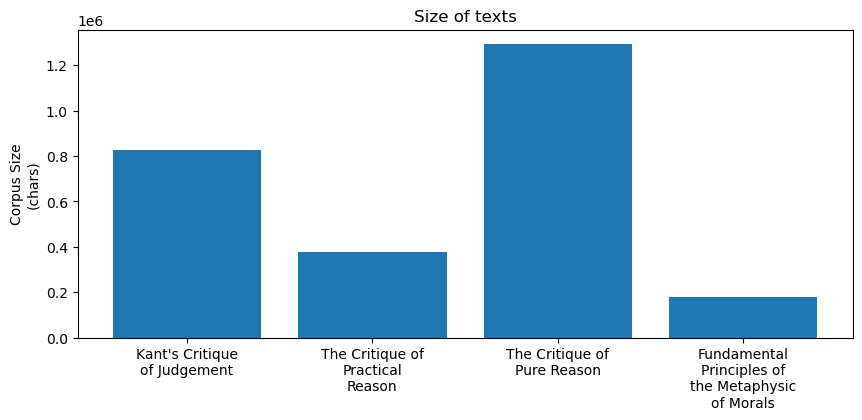

In [ ]:
#Obtaining text lengths
text_lens = [len(text) for text in texts]
print('Lengths of texts: ', text_lens)

#Wrapping text labels
wrapped_titles = [textwrap.fill(title, width=15) for title in text_titles]

#Plotting
fig, ax = plt.subplots(figsize = (10, 4))
bars = ax.bar(wrapped_titles, text_lens)
ax.set(title = 'Size of texts', ylabel = 'Corpus Size\n(chars)')
plt.rcParams.update({'font.size': 10})

### Word Frequencies (per paragraph)

Here, I intend to find the average paragraph length but in words, i.e. obtain the average word counts per paragraph.  We can see here a clear showcasing of the Zipf/Mandelbrot Law which strengthens as we move towards the larger texts.

In [ ]:
def plot_word_freq(ax, text_file, title_doc):

    paras = text_file.split('\r\n\r\n')
    words_per_para = np.array([len(para.split(' ')) for para in paras])
    words_per_para = words_per_para[words_per_para > 100]

    print('\n-----\n')
    print(f'Text: {title_doc}')
    print(f'Mean word count (per paragraph): {np.mean(words_per_para)}')
    print(f'Median word count (per paragraph): {np.median(words_per_para)}')


    ax.hist(words_per_para, bins = 50, alpha = 0.8, histtype = 'bar')
    ax.set(title = f'Word Frequency: {title_doc}\n', xlabel = '\nWord Count (per paragraph)', ylabel = 'Frequency\n')


-----

Text: Kant's Critique of Judgement
Mean word count (per paragraph): 214.6086956521739
Median word count (per paragraph): 186.0

-----

Text: The Critique of Practical Reason
Mean word count (per paragraph): 277.2153846153846
Median word count (per paragraph): 246.0

-----

Text: The Critique of Pure Reason
Mean word count (per paragraph): 214.242656449553
Median word count (per paragraph): 184.0

-----

Text: Fundamental Principles of the Metaphysic of Morals
Mean word count (per paragraph): 212.31578947368422
Median word count (per paragraph): 186.5


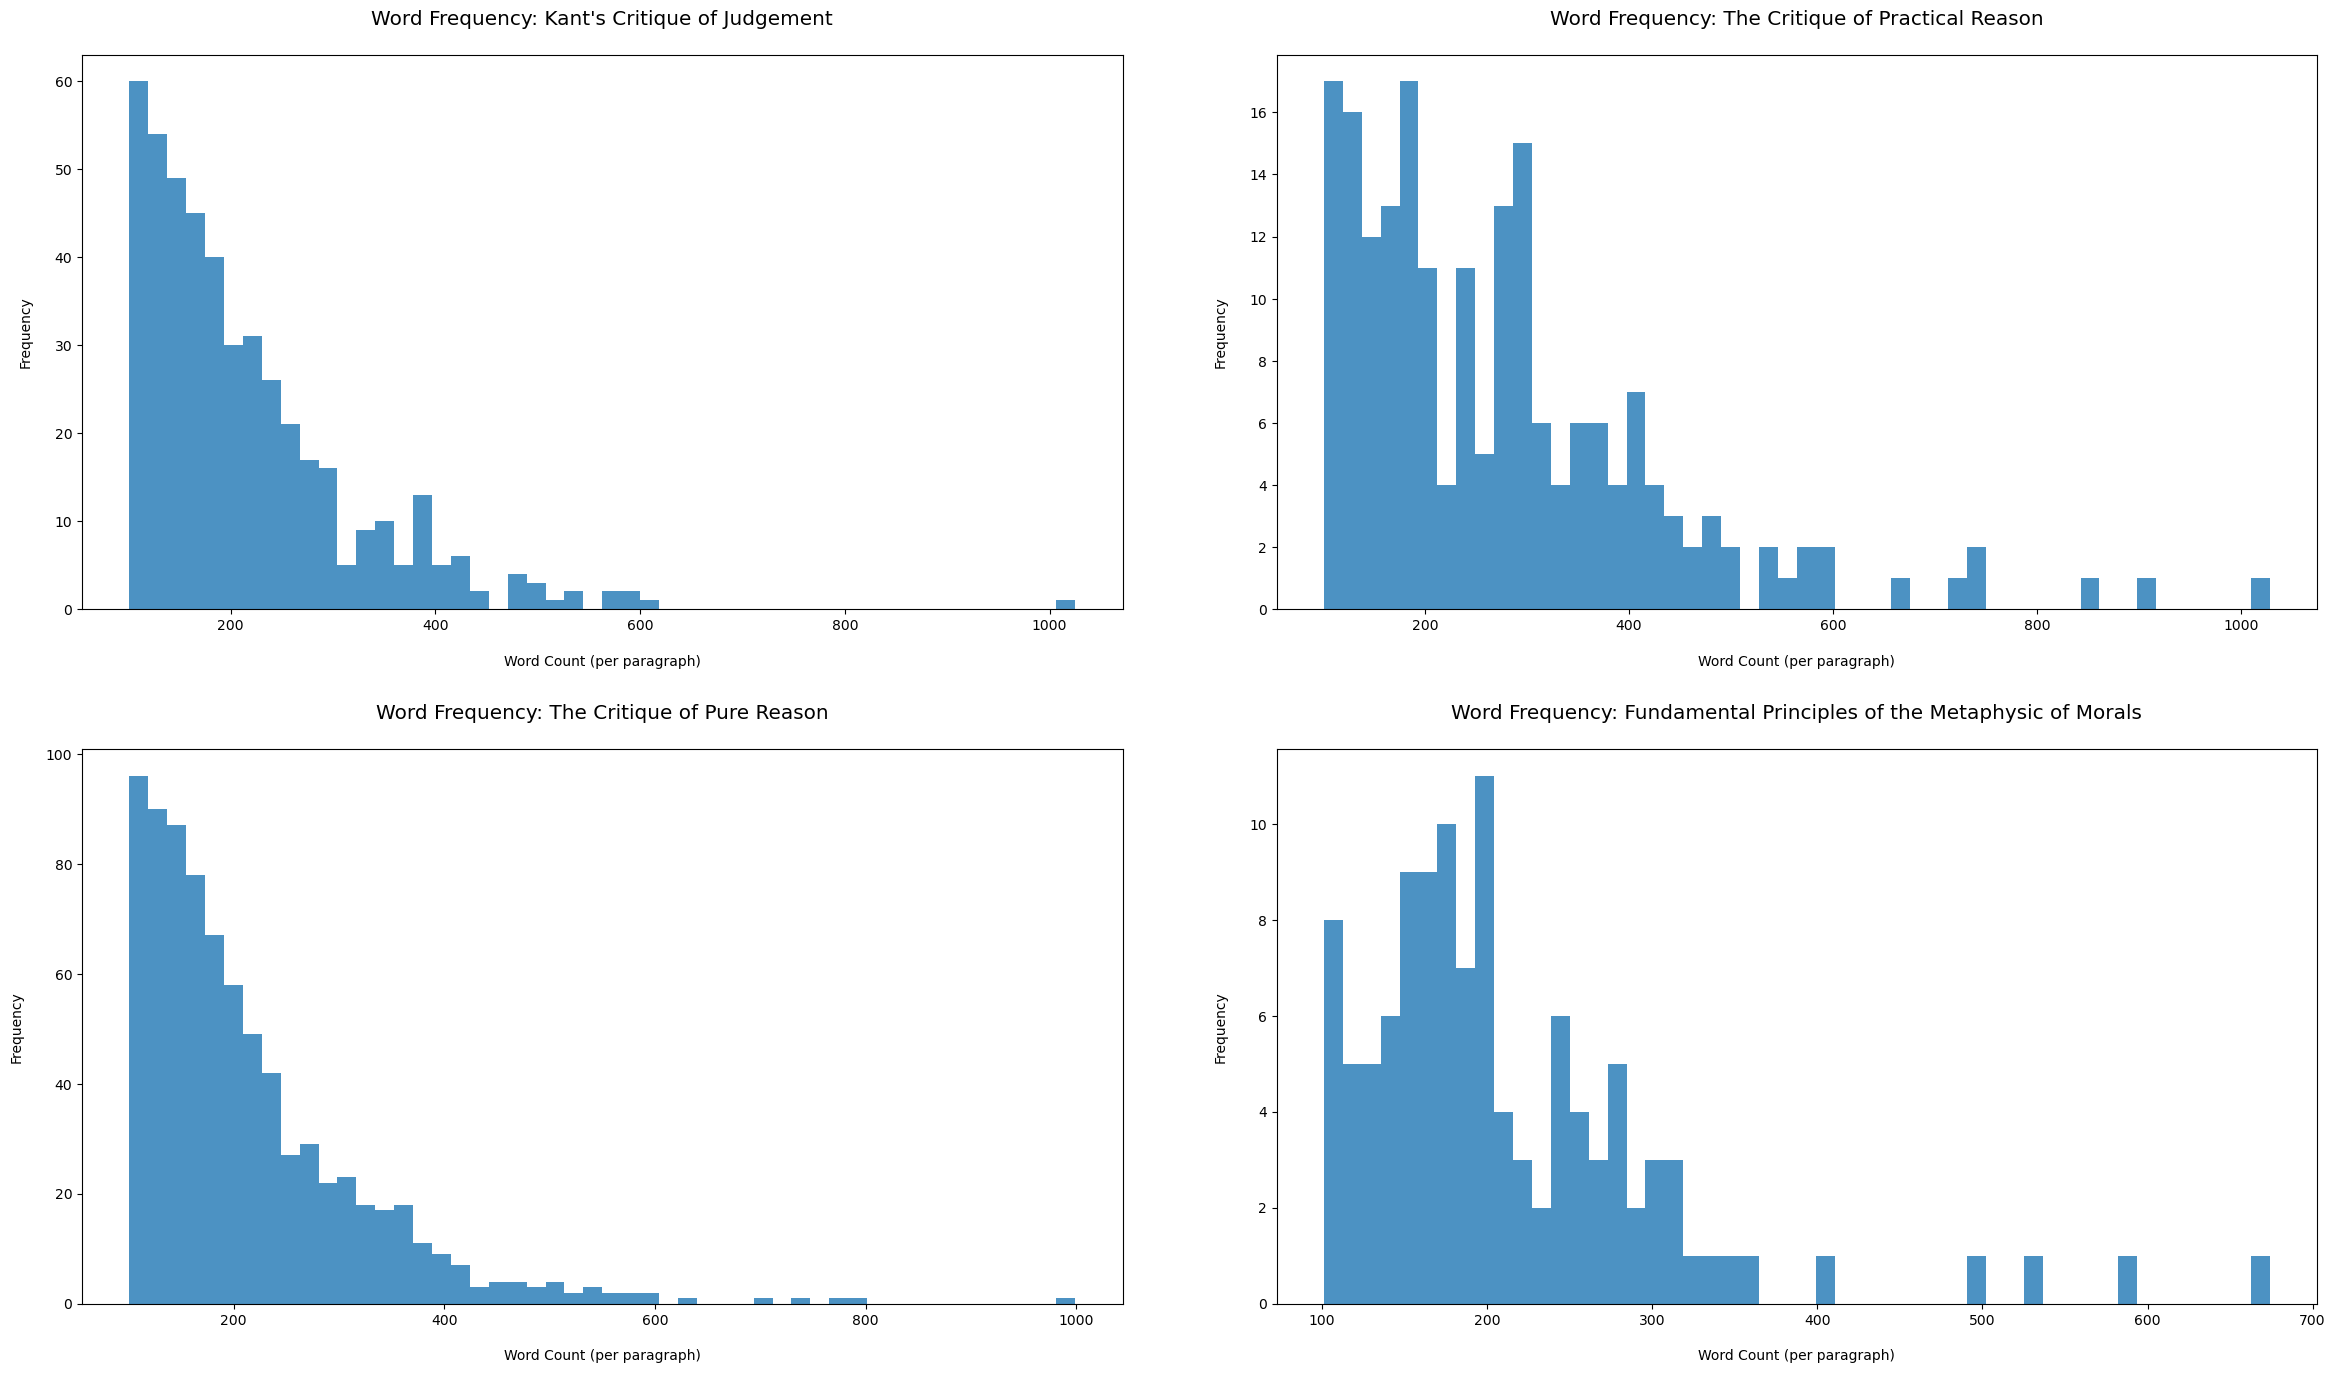

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 15))
fig.tight_layout(pad = 8)
plt.rcParams.update({'font.size': 12})

#Plotting word counts per passage
count = 0

for i in range(2):
    for j in range(2):
        plot_word_freq(ax[i, j], texts[count], text_titles[count])
        count += 1


### Average Sentence and Paragraph Sizes

In this subsection, I analyze the sentence and paragraph lengths of each texts.  

For obtaining the average sentence and paragraph lengths, the median (sentence/paragraph) lengths of each texts is weighted by the normalized text sizes, after which an average is taken.  This gives us the effective average sentence and paragraph sizes of all the documents.  This information is used further down the line to define the chunk size and chunk overlap, which play an important role in the quality of retrieval.  

In [ ]:
#Plots the histogram of sentence and paragraph sizes for a given document
def plot_sent_para_lens(ax, text_file, title_doc, para = True):

    if para: pattern, threshold, name = r'(\r\n\r\n)+', 300, 'Paragraph'    #Paragraph is defined as anything having two new lines at the boundary
    else: pattern, threshold, name = r'(?<=[.!?]) +', 50, 'Sentence'        #Sentence is defined as anything having the symbols '.', '!' or '?' at the boundary

    breaks = np.array([match.start() for match in re.finditer(pattern, text_file)])     #Obtains the positions at which pattern is detected
    lens = breaks[1:] - breaks[:-1]                                                     #Gets the lengths of sentences / paragraphs
    lens = lens[lens > threshold]                                                       #Define a minimum threshold to filter away elements not classifiable as a sentence or paragraph

    #Prints the mean, median lengths
    print('\n-----\n')
    print(f'Text: {title_doc}')
    print(f'Mean {name} length: {np.mean(lens)}')
    print(f'Median {name} length: {np.median(lens)}')

    #Plotting the histogram of sentence/paragraph lengths
    ax.hist(lens, bins = 50, alpha = 0.8, histtype = 'barstacked')
    ax.set(title = f'{name} Size: {title_doc}', xlabel = f'\n{name} Size', ylabel = 'Frequency of occurrence\n')

    return(np.median(lens))

##### Sentence Lengths


-----

Text: Kant's Critique of Judgement
Mean Sentence length: 320.5738347042695
Median Sentence length: 261.0

-----

Text: The Critique of Practical Reason
Mean Sentence length: 412.33734939759034
Median Sentence length: 316.0

-----

Text: The Critique of Pure Reason
Mean Sentence length: 302.7498234878795
Median Sentence length: 246.0

-----

Text: Fundamental Principles of the Metaphysic of Morals
Mean Sentence length: 393.76651982378854
Median Sentence length: 291.0


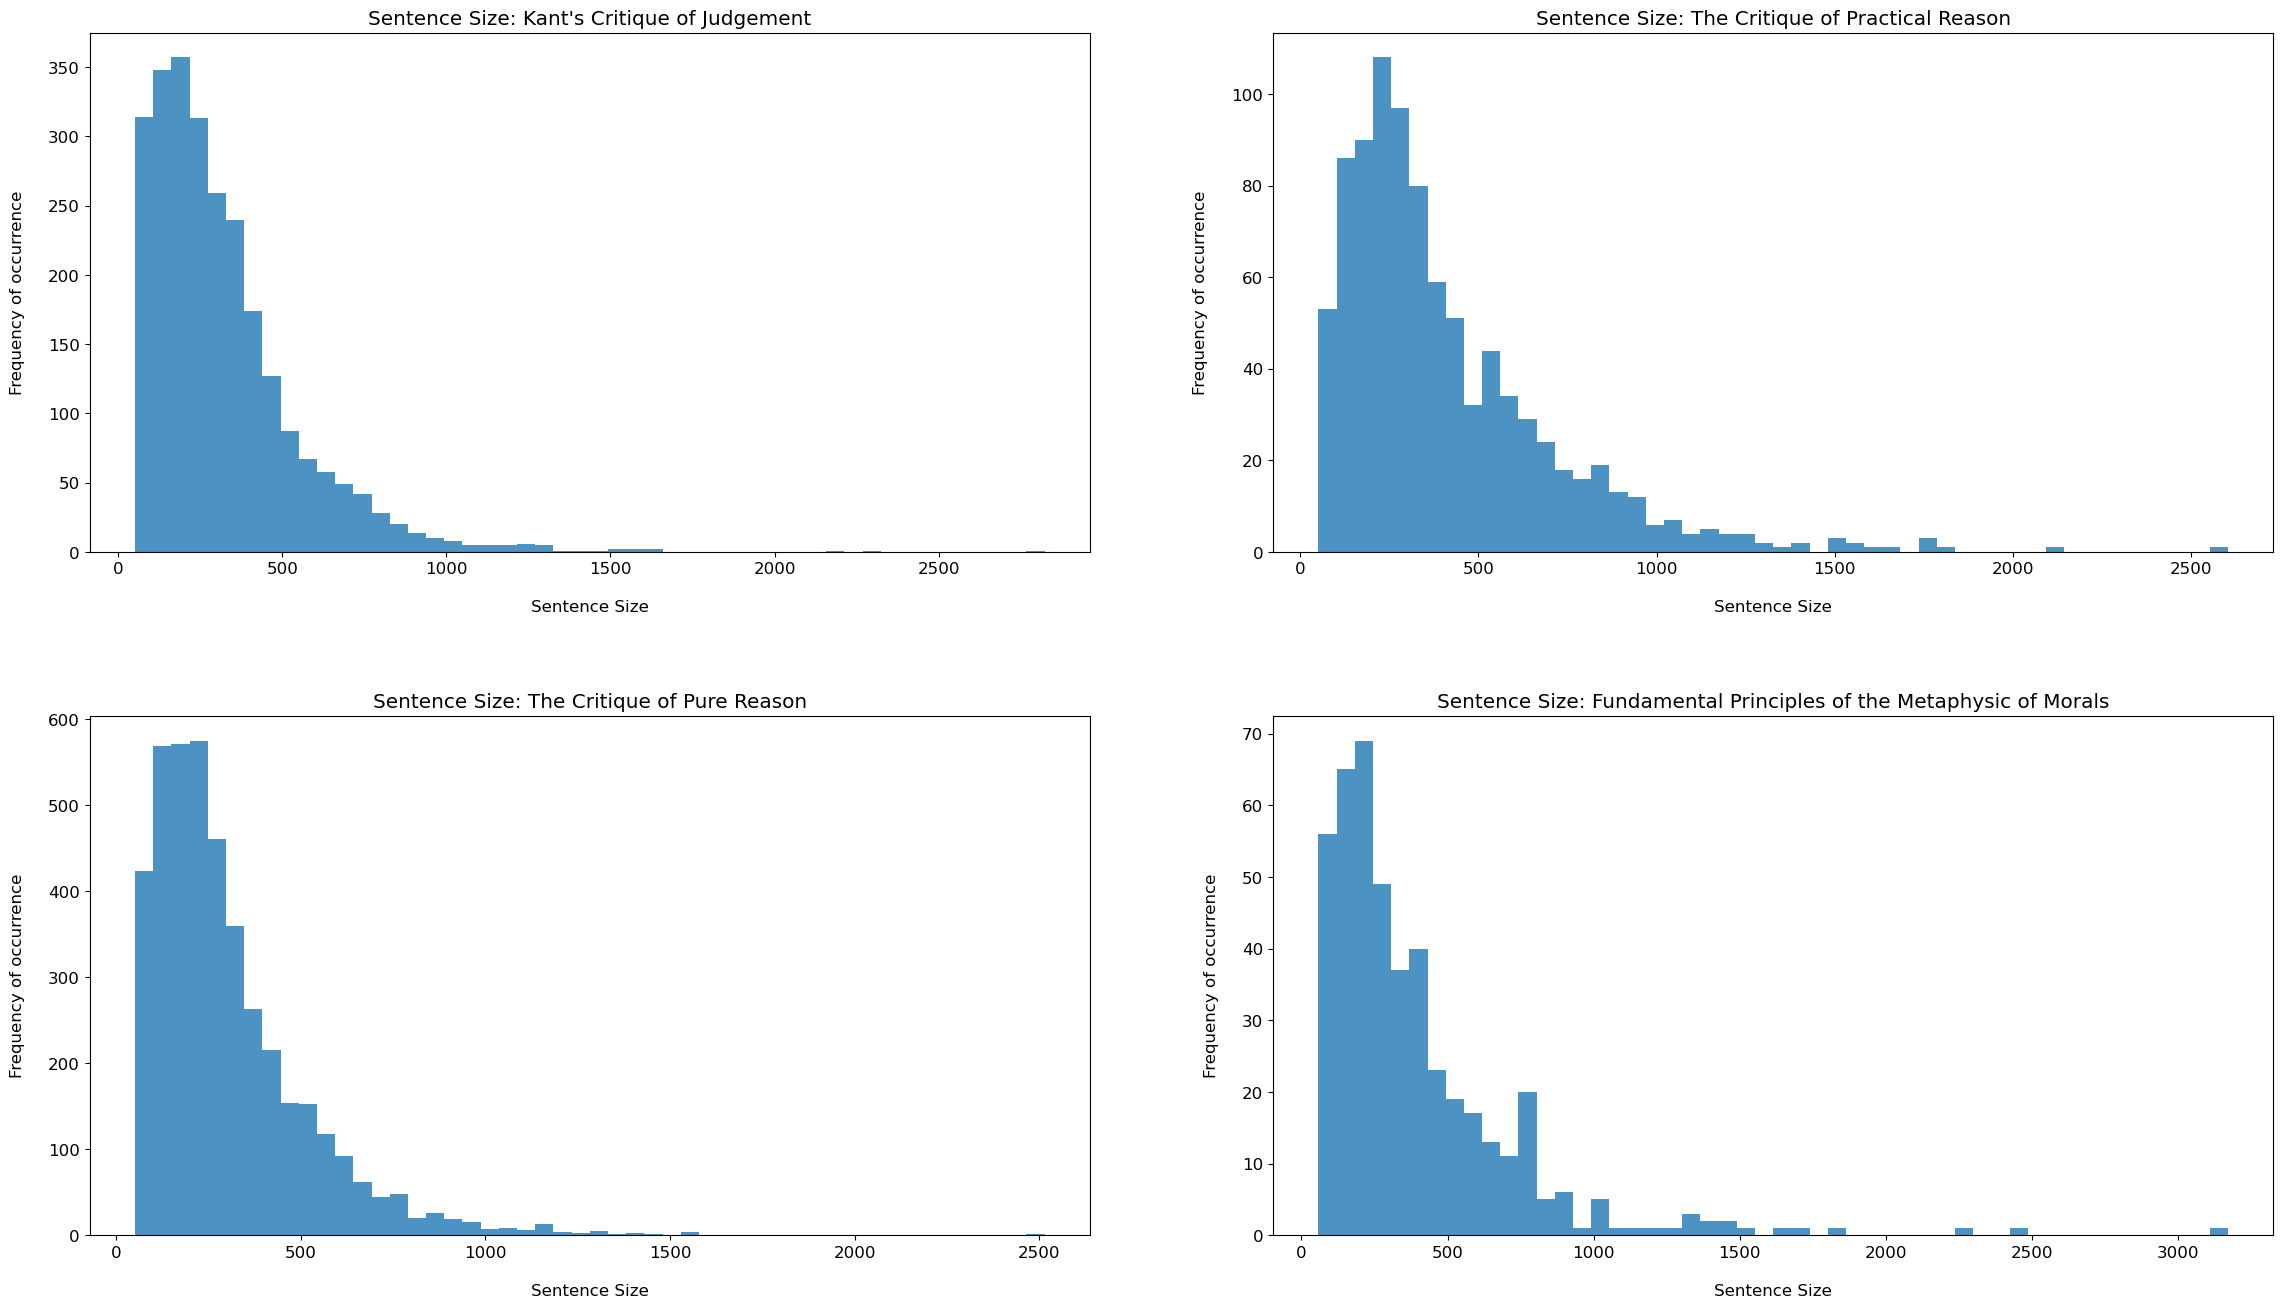

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 15))
fig.tight_layout(pad = 8)
plt.rcParams.update({'font.size': 12})

#Plotting
count = 0
sent_lens_texts = {}

for i in range(2):
    for j in range(2):
        sent_lens_texts[count] = plot_sent_para_lens(ax[i, j], texts[count], text_titles[count], para = False)
        count += 1

In [ ]:
text_weights = np.array(text_lens) / np.sum(text_lens)
sent_mean_weighted = np.sum(text_weights * np.array(list(sent_lens_texts.values())))

print('Weighted mean of sentence (median) lengths: ', sent_mean_weighted)

Weighted mean of sentence (median) lengths:  263.5542200122581


##### Paragraph Lengths


-----

Text: Kant's Critique of Judgement
Mean Paragraph length: 1156.815592203898
Median Paragraph length: 952.0

-----

Text: The Critique of Practical Reason
Mean Paragraph length: 1602.2466960352424
Median Paragraph length: 1342.0

-----

Text: The Critique of Pure Reason
Mean Paragraph length: 1197.7835249042146
Median Paragraph length: 1015.5

-----

Text: Fundamental Principles of the Metaphysic of Morals
Mean Paragraph length: 1083.8509316770187
Median Paragraph length: 1006.0


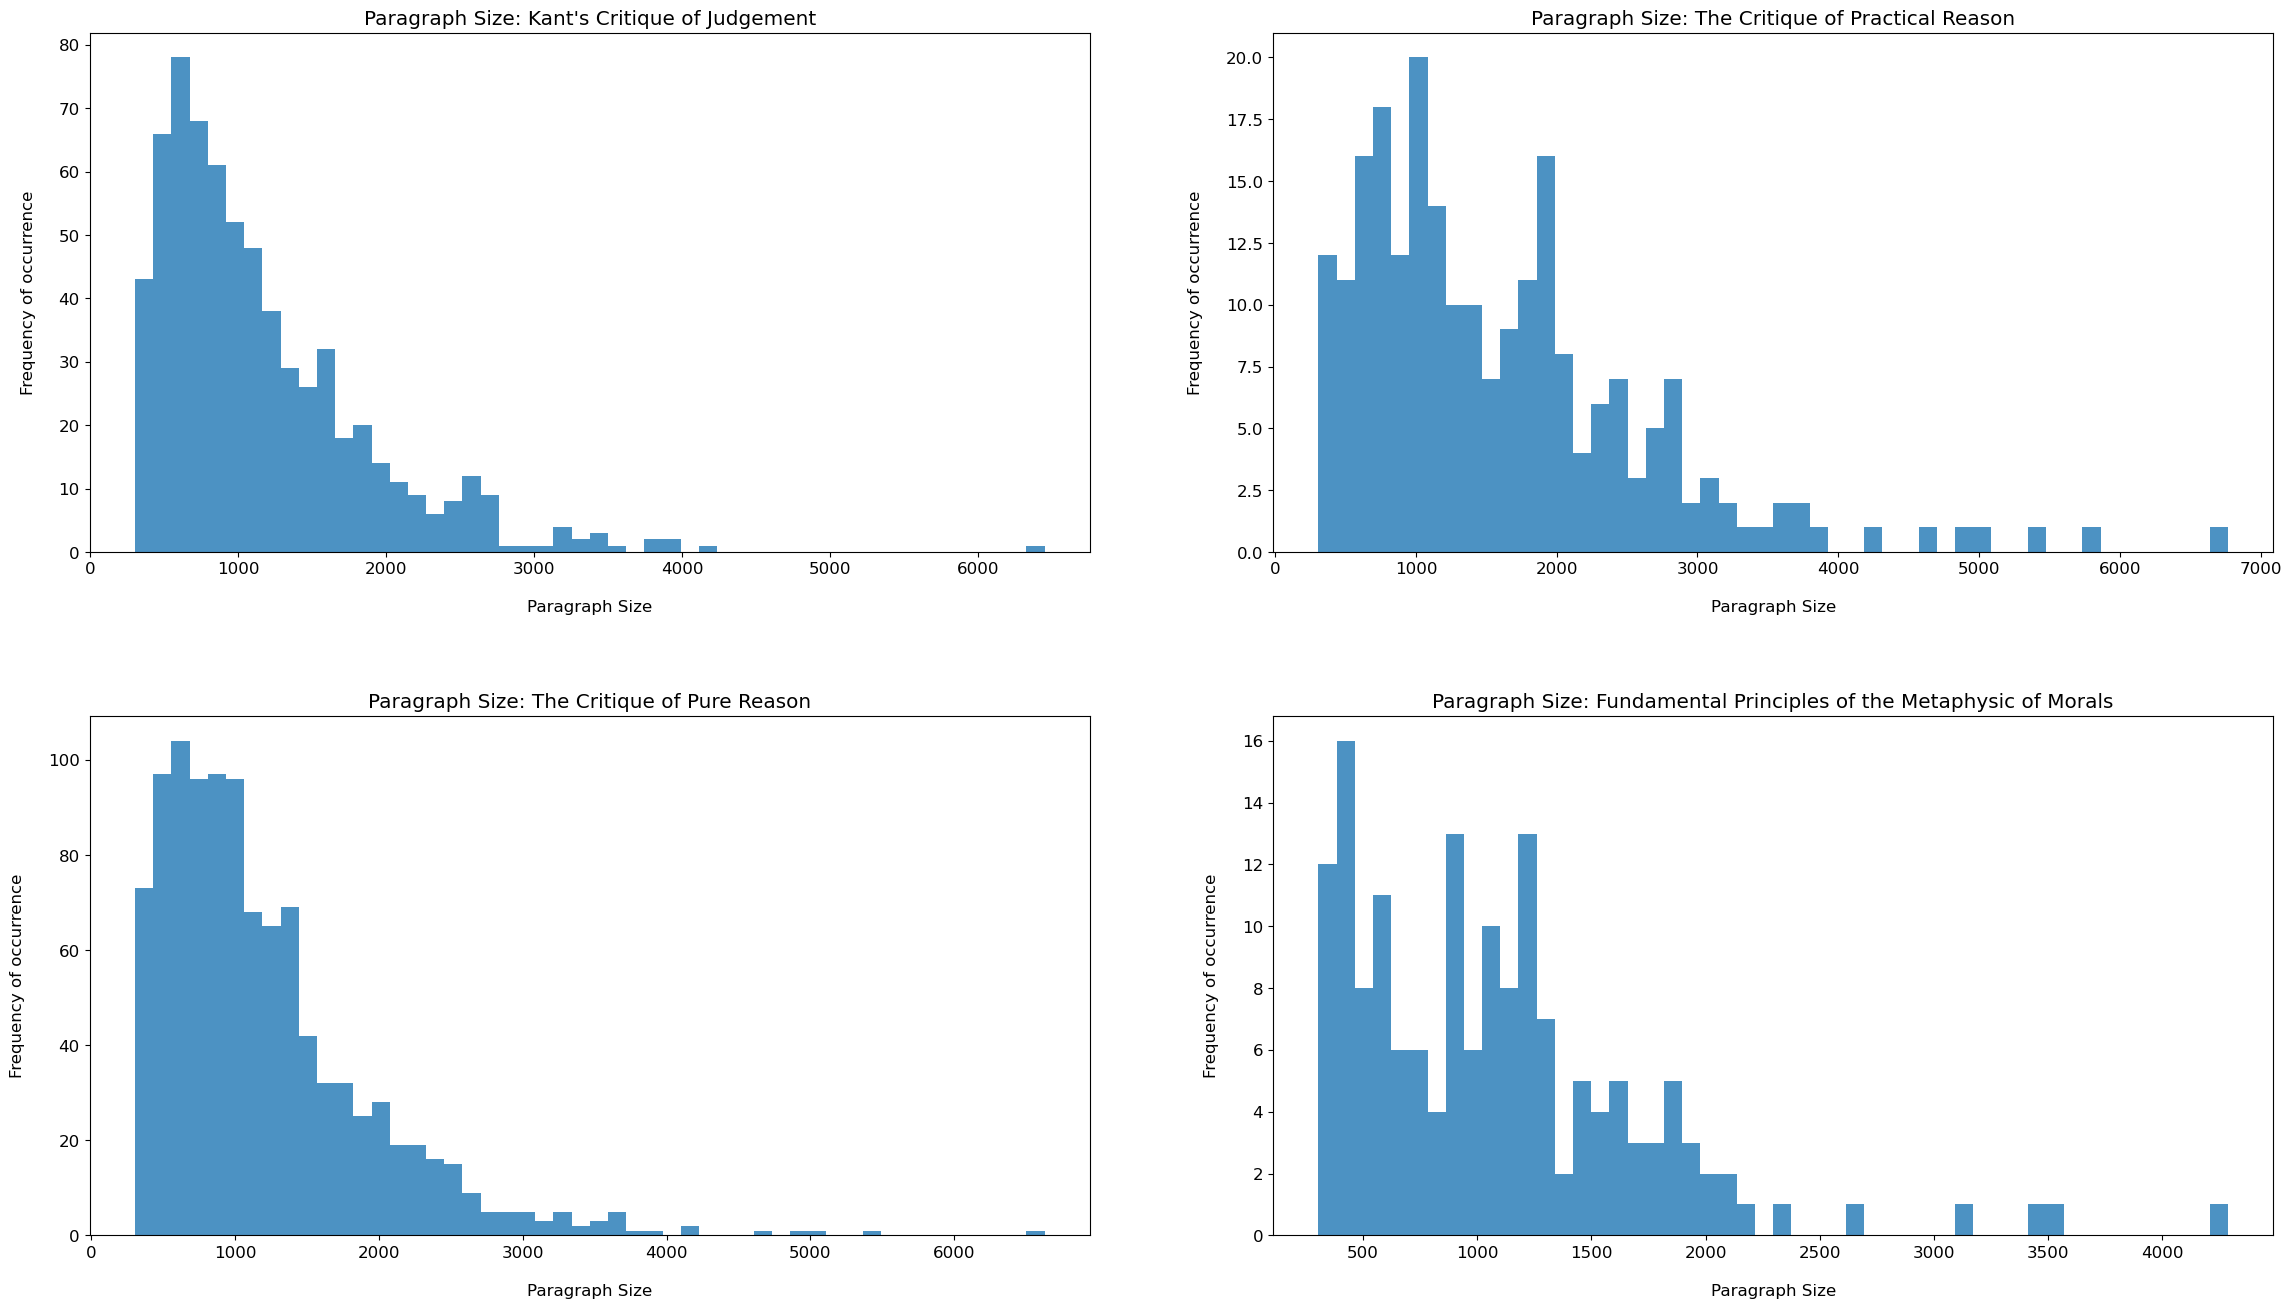

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 15))
fig.tight_layout(pad = 8)
plt.rcParams.update({'font.size': 12})

#Plotting
count = 0
para_lens_texts = {}

for i in range(2):
    for j in range(2):
        para_lens_texts[count] = plot_sent_para_lens(ax[i, j], texts[count], text_titles[count], para = True)
        count += 1

In [ ]:
text_weights = np.array(text_lens) / np.sum(text_lens)
para_mean_weighted = np.sum(text_weights * np.array(list(para_lens_texts.values())))

print('Weighted mean of paragraph (median) lengths: ', para_mean_weighted)

Weighted mean of paragraph (median) lengths:  1041.4388136645985


### Analyzing Types and Tokens

In [ ]:
def plot_token_freq(ax, text_file, title_doc):

    print(f'\n----------\nText: {title_doc}\n')
    print(f'Text Size: {len(text_file)}')

    #Removing Punctuations
    cleaned_text = re.sub(r'[^\w\s]', '', text_file)

    #Tokenizing text
    tokens = nltk.tokenize.word_tokenize(cleaned_text)

    #Removing stop words
    stop_words = set(nltk.corpus.stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]
    print(f'Number of Tokens: {len(tokens)}')

    n_types = len(set(filtered_tokens))
    print(f'Number of Types (Vocabulary): {n_types}')

    ttr_val = n_types/len(filtered_tokens)
    print(f'Type-Token Ratio: {ttr_val}')

    #Obtaining frequency distribution of words
    freq_dist = nltk.probability.FreqDist(filtered_tokens)

    #Plotting
    plot_data = freq_dist.most_common(40)
    common_tokens, f_tokens = np.array(plot_data).T

    ax.bar(common_tokens, f_tokens.astype(int))
    ax.set(ylabel = 'Counts\n', title = f'Top 40 Tokens: {title_doc}')
    ax.tick_params(axis='x', labelrotation=90, labelsize=10)

    return(ttr_val)


----------
Text: Kant's Critique of Judgement

Text Size: 766930
Number of Tokens: 125819
Number of Types (Vocabulary): 7743
Type-Token Ratio: 0.13205198171771607

----------
Text: The Critique of Practical Reason

Text Size: 377956
Number of Tokens: 62954
Number of Types (Vocabulary): 3970
Type-Token Ratio: 0.1394352346164653

----------
Text: The Critique of Pure Reason

Text Size: 1291282
Number of Tokens: 209624
Number of Types (Vocabulary): 8040
Type-Token Ratio: 0.08328240400252748

----------
Text: Fundamental Principles of the Metaphysic of Morals

Text Size: 180176
Number of Tokens: 30886
Number of Types (Vocabulary): 2539
Type-Token Ratio: 0.18706255065202976


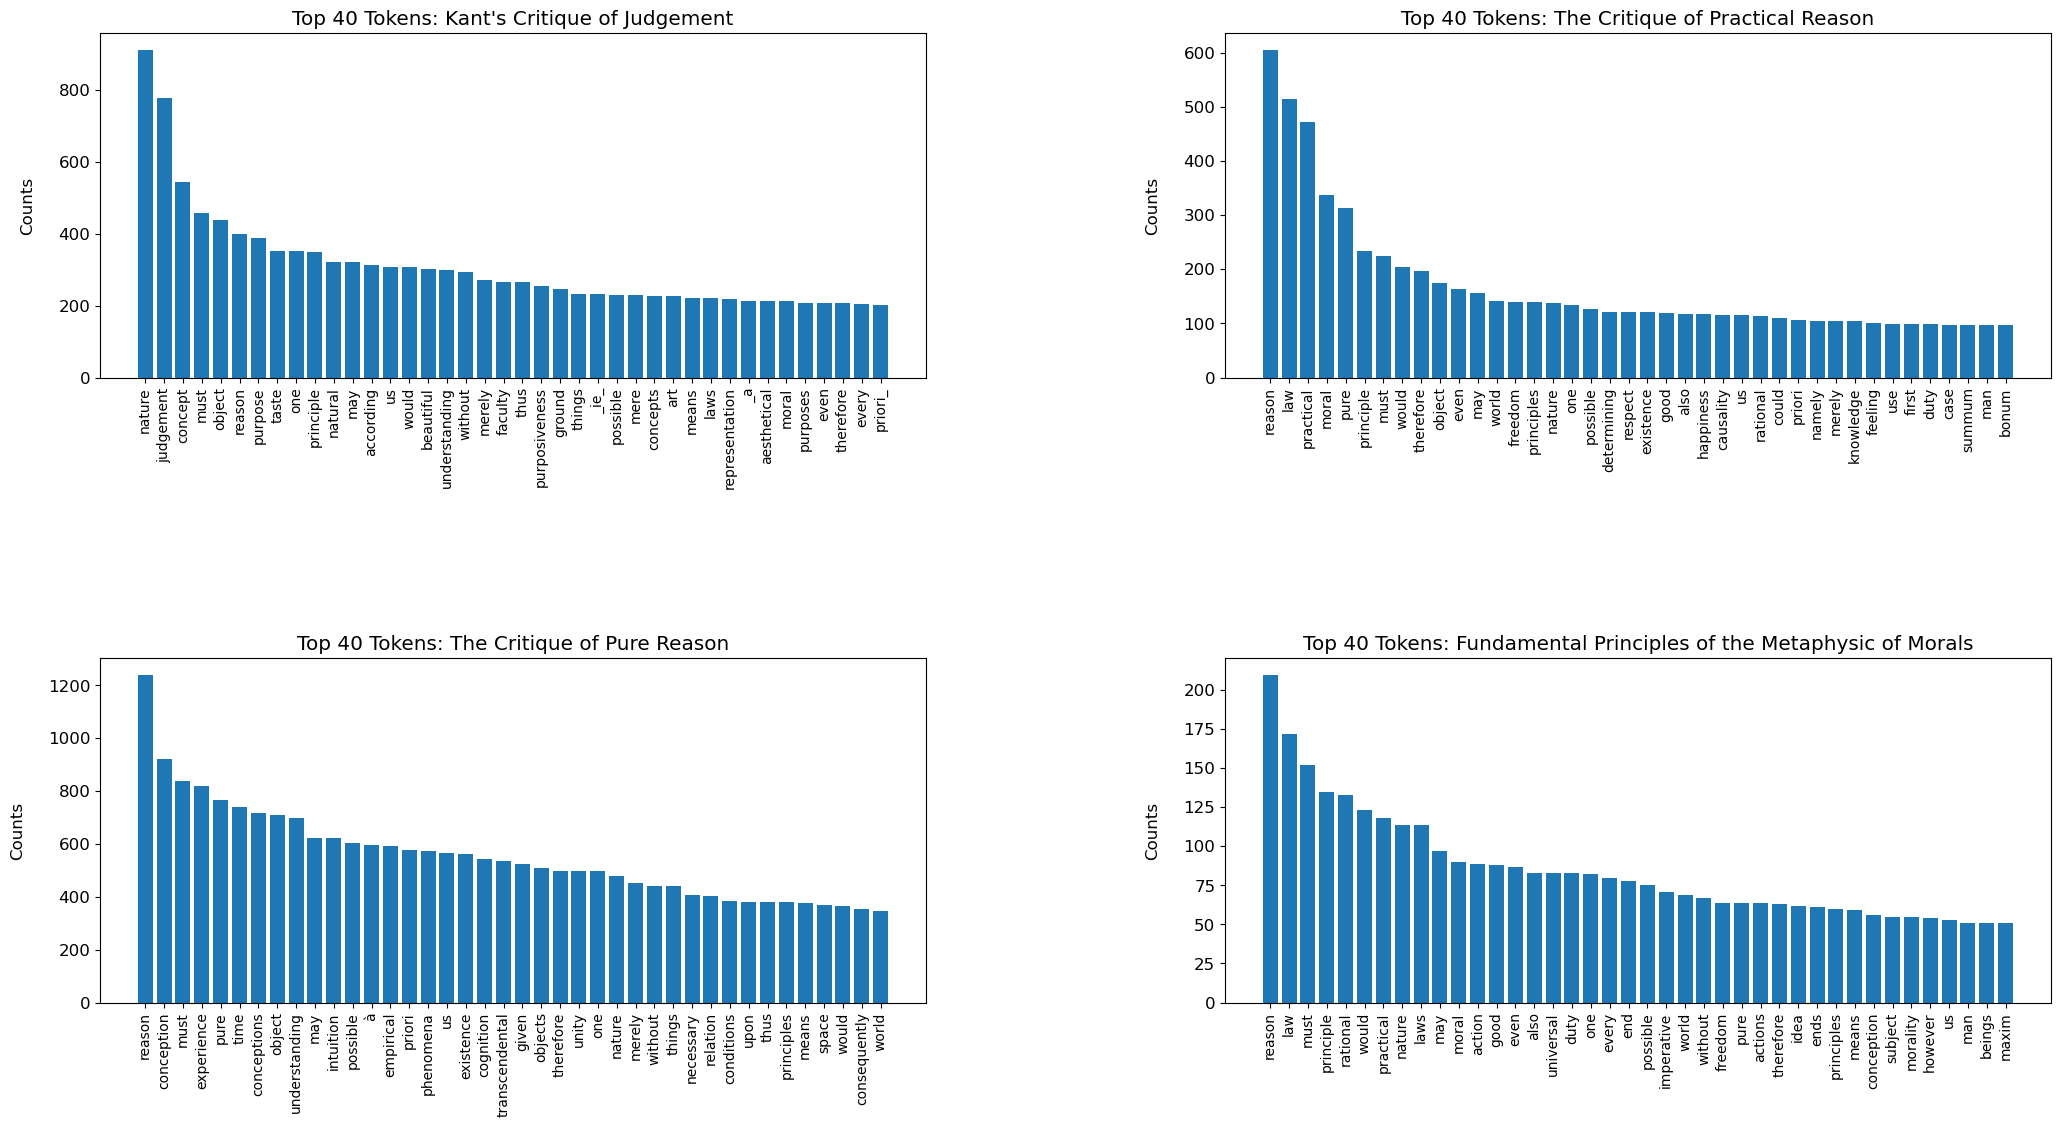

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 15))
fig.tight_layout(pad = 15)

TTR_texts = {}
count = 0

for i in range(2):
    for j in range(2):
        TTR_texts[count] = plot_token_freq(ax[i, j], texts[count], text_titles[count])
        count += 1


## Document Pre-Processing and Parsing

### Trimming Documents and Adding Line Numbers

- Trimming Documents:  This is to ensure that the parts not belonging to the original text, like information about the Project Gutenberg, where the documents were sourced from, is not present further down the line.

- Adding Line Numbers:  This adds line numbers to each line of the text.  Further down, we use this to add line numbers to the metadata, which will then be useful to refer to during the retrieval process.

In [ ]:
def trim_document(filename, from_del = None, till_del = None):
    # Read the content of the file
    with open(filename, 'r') as file:
        content = file.read()

    # Find the position of the delimiter
    if from_del is None: from_pos = 0
    else: from_pos = content.find(from_del)

    if till_del is None: till_pos = len(content)
    else: till_pos = content.find(till_del)

    if from_pos == -1 or till_pos == -1:
        print("Delimiter not found in the file.")
        return

    print(from_pos, till_pos)

    # Write the content starting from the delimiter to the same file
    new_filename = filename[:-4] + '_trimmed' + '.txt'
    with open(new_filename, 'w') as file:
        file.write(content[from_pos : till_pos])

In [ ]:
def add_line_numbers(filename):

    new_filename = filename[:-4] + '_lined' + '.txt'

    with open(filename, 'r') as ref_file, open(new_filename, 'w') as lined_file:

        for n_line, line in enumerate(ref_file):
            lined_file.write(f'{n_line}: {line}')

    print('Finished writing new file')

In [ ]:
for doc in file_paths:
    trim_document(doc, from_del = 'Title', till_del = '*** END OF THE PROJECT GUTENBERG EBOOK')
    add_line_numbers(doc)

Finished writing new file
Finished writing new file
Finished writing new file
Finished writing new file


### Chunking Data

When chunking the data, we deal with two parameters: <br>
- Chunk Size:  This is the number of characters in a chunk.  A larger chunk size will correspond to capturing long range global dependencies, while a smaller chunk size will correspond to capturing local semantics and nuances.  <br><br>

- Chunk Overlap:  This controls how correlated one chunk is with the next one.  More correlation means more information shared by the chunks will be picked up on, leading to clustering their respective embeddings in a closeby region in the embedding space.

In [7]:
docs = [file_path_gen(i) for i in range(1, 5)]
docs

['/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt',
 '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt']

In [8]:
def chunk_docs(docs_paths, chunk_size = 1041, chunk_overlap = 260):

    #Loading the documents
    docs_loaded = []

    for doc in docs_paths:
        loader = TextLoader(doc)
        data = loader.load()
        docs_loaded.extend(data)

    print(f'Number of docs loaded: {len(docs_loaded)}')

    #Chunking documents
    chunk_func = RecursiveCharacterTextSplitter(
                        chunk_size = chunk_size,
                        chunk_overlap = chunk_overlap,
                        length_function = len)

    #Maps the chunking function to the documents
    docs_chunked = chunk_func.transform_documents(docs_loaded)
    print(f'Number of chunks: {len(docs_chunked)}')

    return(docs_chunked)

In [9]:
docs_chunked = chunk_docs(docs, chunk_size = 1041, chunk_overlap = 260)

Number of docs loaded: 4
Number of chunks: 3729


### Adding Line numbers to Metadata

Here, we process a file that contains line numbers in the text data, and we shift the line numbers over to the meta data, clearing the texts of it.  This ensures two things:
- The documents are legible without the numbers hindering the readability.
- Having the line numbers in the metadata makes sure that the retrieved documents have a reliable marker as to where the information is present in the text

In [10]:
#Wraps text when printing output
def print_wrap(s):
    s_wrap = textwrap.fill(s, width = 100)
    print(s_wrap)

#Print metadata and content as wrapped text
def print_doc(doc):
    print('Metadata: ', doc.metadata)
    print('\nContent:\n')
    print_wrap(doc.page_content)

print_doc(docs_chunked[0])

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt'}

Content:

0: Title: Kant's Critique of Judgement 1:  2: Author: Immanuel Kant 3:  4: Translator: J. H. Bernard
5:  6: Release date: March 8, 2015 [eBook #48433] 7:  8: Language: English 9:  10: Credits: Produced
by Charlie Howard and the Online Distributed 11:         Proofreading Team at http://www.pgdp.net
(This file was 12:         produced from images generously made available by The 13:
Internet Archive) 14:  15:  16: *** START OF THE PROJECT GUTENBERG EBOOK KANT'S CRITIQUE OF
JUDGEMENT *** 17:  18:  19:  20:  21: Produced by Charlie Howard and the Online Distributed 22:
Proofreading Team at http://www.pgdp.net (This file was 23: produced from images generously made
available by The 24: Internet Archive) 25:  26:  27:  28:  29:  30:  31:  32:  33:  34:
Transcriber's note: Boldface text is enclosed in =equals signs=; 35:   italicized text is enclosed
in _underscores_. Other notes will be 36:   found a

In [11]:
#Add the line numbers in each document to its metadata
def lines_to_meta(doc):

    content = doc.page_content  #Get the content of document

    #Get matches for pattern integer: or \ninteger:.  For example: '0:', '\n50:'
    matches = re.finditer(r'(?:\n|^)(\d+):', content)
    lines_pos = [match.span() for match in matches]

    #Gets the strings of the patterns
    line_strings = [content[span[0]:span[1]] for span in lines_pos]

    #Deletes the line numbers from the content
    del_strings = '|'.join(line_strings)
    content_trimmed = re.sub(del_strings, '', content)

    #Updates the content and adds lines info to the metadata
    doc.page_content = content_trimmed
    doc.metadata['Lines'] = sorted([int(s[0:-1]) if s[0] != '\n' else int(s[1:-1]) for s in line_strings[::len(line_strings)-1]])

    return(None)


In [12]:
#Applies the above function to the chunked data
list(map(lines_to_meta, docs_chunked))

#Adding Document Number to metadata
for id, doc in enumerate(docs_chunked):  doc.metadata['id'] = id

example = docs_chunked[0]
print_doc(example)

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [0, 44], 'id': 0}

Content:

 Title: Kant's Critique of Judgement  Author: Immanuel Kant  Translator: J. H. Bernard  Release
date: March 8, 2015 [eBook #48433]  Language: English  Credits: Produced by Charlie Howard and the
Online Distributed         Proofreading Team at http://www.pgdp.net (This file was         produced
from images generously made available by The         Internet Archive)   *** START OF THE PROJECT
GUTENBERG EBOOK KANT'S CRITIQUE OF JUDGEMENT ***     Produced by Charlie Howard and the Online
Distributed Proofreading Team at http://www.pgdp.net (This file was produced from images generously
made available by The Internet Archive)          Transcriber's note: Boldface text is enclosed in
=equals signs=;   italicized text is enclosed in _underscores_. Other notes will be   found at the
end of this eBook.       KANT’S   CRITIQUE OF JUDGEMENT


## Creating Vector Store

Here, I create the vector store, using FAISS, with which we can efficiently do similarity search in the embedding space.  In order to speed up the search further, the embedding model is saved in a local directory.  

In [13]:
def create_vector_store(embedding_model_id, docs_chunked):

    #Calls for embedding model
    embeddings_model = HuggingFaceEmbeddings(
        model_name=embedding_model_id
    )

    #Caching the embeddings
    #store_path = r"E:\Academics\UniPD\Courses\Semester_4\NLP\cache"
    store_path = "./cache/"
    store = LocalFileStore(store_path)

    embedder = CacheBackedEmbeddings.from_bytes_store(
        embeddings_model, store, namespace=embedding_model_id
    )

    #Creating vector store using FAISS
    vector_store = FAISS.from_documents(docs_chunked, embedder)

    return(vector_store, embeddings_model)

## Retrieval Chain

### Obtaining LLM and Retriever

This defines the pipeline for the LLM Model.  I use the Llama-2 model with 7 billion parameters ("meta-llama/Llama-2-7b-chat-hf") as the ChatBot LLM.  Even with 7 billion, I found that quantization was a necessity to get the pipline to function without it leading to GPU overload.

In [15]:
def get_llm_pipeline(llm_model_id, quantization = True, temperature = 0.001):


    #Implementing parameter quantization
    bnb_config = transformers.BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type='nf4',
        bnb_4bit_use_double_quant=True,
        bnb_4bit_compute_dtype=torch.bfloat16
    )

    #Loading the model configuration
    model_config = transformers.AutoConfig.from_pretrained(llm_model_id)

    #Loading the pretrained model
    model = transformers.AutoModelForCausalLM.from_pretrained(
        llm_model_id,
        config=model_config,
        quantization_config=bnb_config if quantization else None,
        trust_remote_code=True,
        device_map='auto'
    )

    #Loading the model tokenizer
    tokenizer = transformers.AutoTokenizer.from_pretrained(llm_model_id)

    model_pipeline = transformers.pipeline(
        model=model,
        tokenizer=tokenizer,
        task="text-generation",
        return_full_text=True,
        temperature=temperature,
        max_new_tokens=250
    )

    #Obtaining the final LLM pipeline and retriever
    llm = HuggingFacePipeline(pipeline=model_pipeline)

    return(llm)

### Obtaining Chain with defined prompt template

This defines a custom LLM Chain, where we can define a prompt template.  

In [ ]:
#Defining the prompt template
template = """ Question: {query}

----
Constraint: Use the following information to answer the above question.  Answer only
if you are confident, else say you are not sure.

----
Information: {similar_docs}

----
Answer:
"""

#Constructing chain with prompt
prompt = PromptTemplate(template = template, input_variables=["query", "similar_docs"])
llm_chain = LLMChain(llm = llm, prompt = prompt)

### Master Function

This defines a master function with the tunable parameters as its arguments.  This allows for easy iterations while searching for the optimal parameters.

In [16]:
def master_func(docs_paths, embedding_model_id, llm_model_id,
                    chunk_size, chunk_overlap,
                    quantization, temperature,
                    prompt_template, template_input_vars):

        #Chunking documents
        print('Chunking...')
        docs_chunked = chunk_docs(docs_paths, chunk_size, chunk_overlap)

        #Applies function to the chunked data and adds lines to the metadata
        list(map(lines_to_meta, docs_chunked))

        #Create Vector store
        print('Creating Vector Store...')
        vector_store, embeddings_model = create_vector_store(embedding_model_id, docs_chunked)

        #Obtain LLM and Retriever
        print('Creating Pipeline...')
        llm = get_llm_pipeline(llm_model_id, quantization = quantization, temperature = temperature)

        #Constructing chain with prompt
        print('Constructing Chain...')
        prompt = PromptTemplate(template = prompt_template, input_variables=template_input_vars)
        llm_chain = LLMChain(llm = llm, prompt = prompt)

        return(llm_chain, vector_store, embeddings_model)

### Querying the Retrieval System

We obtain the answer to the query, given the query, LLM Chain and the embeddings model.

In [17]:
#Querying the LLMChain that uses prompt template
def get_answer_LLMChain(query, chain, embeddings_model, vector_store, print_source_docs = True):

    #We first obtain the k-similar docs near the query to feed into the prompt before running the chain
    #Obtaining the query embedding, using which we get the k-similar docs
    query_embedding = embeddings_model.embed_query(query)
    query_sim_docs = vector_store.similarity_search_by_vector(query_embedding, k = 4)

    #Obtaining just the content of the docs into one string
    query_sim_docs_content = ''.join([doc.page_content for doc in query_sim_docs])

    #Running LLMChain using the query and obtained similar docs
    answer = chain.run(query = query, similar_docs = query_sim_docs_content)

    #Printing the answer as a wrapped text output for ease in reading
    answer_wrap = textwrap.fill(answer, width = 100)
    next_line_pos = [m.start() for m in re.finditer('----', answer_wrap)]   #Gets the positions of new line marker
    for i, pos in enumerate(next_line_pos):
        answer_wrap = answer_wrap[:pos + 2*i] + '\n\n' + answer_wrap[pos + 2*i:]    #Adds new line to desired places

    print(answer_wrap)

    #Prints the source docs as wrapped text output
    if print_source_docs:
        print(f'\n\n--------\nSource Documents ({len(query_sim_docs)} sources shown)')

        for i, doc in enumerate(query_sim_docs):
            print(f'\nSource {i}:')
            print('\nMetadata: ', doc.metadata)
            print('\nPage Content:\n')
            print_wrap(doc.page_content)
            print('-----')


## Queries Chosen

The queries were chosen to represent commonly found types of queries in a retrieval system.  

- Type 1 (Direct): I have chosen three direct and straightforward queries, which is a basic retrieval task to find a definition among the documents.  This requires the retreival system to correctly find the related documents from the embedding space and provide it to the LLM.

- Type 2 (Analysis): I have chosen two challenging questions that test the model on two regards.  
    - Firstly, these queries require contextual analysis of ideas that span through sentences or paragraphs, thereby testing the model on if it understand long-span contexts.  
    - Secondly, these questions are slightly iterated versions of the above direct questions, thereby testing the model on its capability of understanding the true semantics of the query despite the more complex paraphrasing.  

<br>
The questions considered as follows:

- Direct: What is meant by moral law?
- Direct: What is transcendental idealism?
- Direct: What is the categorical imperative?

- Analysis: How does the formulation of the categorical imperative establish a foundation for universal moral laws, and what are the implications for individual autonomy?
- Analysis: How does transcendental idealism distinguish between phenomena and noumena, and what are the philosophical implications of this distinction for human cognition and metaphysics?

In [18]:
queries = [
    'What is meant by moral law?',
    'What is transcendental idealism?',
    'What is the categorical imperative?',

    'How does the formulation of the categorical imperative establish a foundation for universal moral laws, and what are the implications for individual autonomy?',
    'How does transcendental idealism distinguish between phenomena and noumena, and what are the philosophical implications of this distinction for human cognition and metaphysics?',

    'How does Kant’s treatment of ethical duties in the Fundamentals of the Metaphysic of Morals differ from his approach in the Critique of Practical Reason?'
]

## Varying Models, Parameters and Prompts

I have tried varying the below models, parameters, and prompts.  With the help of the queries defined above, and the results produced by each, I found the optimal values (colored <span style="color:  #068a6c ">__green__</span>).  An explanation on why these were found to be optimal is given in its respective subsection, where I have explained the observations and results, along with the data generated.  The retrieved data contains both the book and the line numbers the document was retrieved from, which pinpoints the source up to the line number.

<br>

- Varying Embedding Models:
    - General Embedding Model: 'sentence-transformers/all-MiniLM-L6-v2'
    - <span style="color:  #068a6c ">__MS-MARCO Embedding Model: 'sentence-transformers/msmarco-MiniLM-L-6-v3'__</span>

<br>

- Varying Parameters:
    - Maximum Token Size: [<span style="color:  #068a6c ">__250__</span>, 500]
    - Chunk Sizes: [264, <span style="color:  #068a6c ">__1041__</span>]
    - Chunk Overlap: [0, <span style="color:  #068a6c ">__66__</span>]/[0, <span style="color:  #068a6c ">__260__</span>]
    - Temperature: [0.001, <span style="color:  #068a6c ">__0.1__</span>, 0.25]

<br>

- Varying Prompt Templates:
    - Straightforward prompt with no constraint    
    - <span style="color:  #068a6c ">__Prompt with constraint__</span>
    - Prompt with constraint and Justification

In [19]:
#Initializing variables
def init_variables():

    embedding_model_id = 'sentence-transformers/all-MiniLM-L6-v2'
    llm_model_id = 'meta-llama/Llama-2-7b-chat-hf'

    chunk_size, chunk_overlap = 1041, 260
    quantization, temperature = True, 0.1

    prompt_template =  """ Question: {query}

    ----
    Constraint: Use the following information to answer the above question.  Answer only
    if you are confident, else say you are not sure.

    ----
    Information: {similar_docs}

    ----
    Answer:
    """

    template_input_vars = ["query", "similar_docs"]

    return( embedding_model_id, llm_model_id,
           chunk_size, chunk_overlap,
           quantization, temperature,
           prompt_template, template_input_vars)

In [ ]:
#Initializing variables
embedding_model_id, llm_model_id, chunk_size, chunk_overlap, quantization, temperature, prompt_template, template_input_vars = init_variables()

#Defining the embedding model id variable with new value
chunk_size, chunk_overlap = 264, 66

#Obtain the vector store and llm chain
llm_chain, vector_store, embeddings_model = master_func(docs,
                                      embedding_model_id, llm_model_id,
                                      chunk_size, chunk_overlap,
                                      quantization, temperature,
                                      prompt_template, template_input_vars)

In [24]:
#Sample output: Testing the formatting of the output and readability
query = queries[1]
get_answer_LLMChain(query = query, chain = llm_chain, embeddings_model = embeddings_model, vector_store = vector_store, print_source_docs=True)

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  Therefore the world—the content of all phenomena—is not a whole existing in
itself. It follows that phenomena are nothing, apart from our representations. And this is what we
mean by transcendental ideality. transcendental ideal which forms the basis of the complete
determination of everything that exists, and is the highest material condition of its possibility—a
condition on which must rest the the length of maintaining that this internal experience is of
itself a sufficient proof of the real existence of its object as a thing in itself.  Transcendental
idealism allows that the objects of external is on this account transcendent.  Section II. Of the
Transcendental Ideal (Prototypon Trancendentale)  Every conception is, in relation to that which is
not contained in

### Varying Embedding Models

Here, I choose two different embedding models, one trained in a more general setting, while the other one trained with focus on a specific dataset made for QA tasks, and compare which performed better in the domain of philosophy.  I wanted to see if a general trained model would pick up more on the contexual clues and be better in understanding long-range dependencies than a model trained on a typical standard QA dataset, especially when dealing with a complex philosophical piece of text.


- General Embedding Model ('sentence-transformers/all-MiniLM-L6-v2'): This a general purpose distilled embedding model. It is intended to be used as a sentence and short paragraph encoder.  The training data is general data which includes WikiAnswers, MS-MARCO, Stack Exchange, and so on.  

    Using this model, the retrieved documents seem to be much better aligned with the query, which in turn makes the answers more clear and legible.  It answers every question, from the straightforward ones to the challenging ones, confidently.

<br>

- MS-MARCO Embedding Model ('sentence-transformers/msmarco-MiniLM-L-6-v3'): This is a sentence-transformer model based on the S-BERT architecture, trained largely on the MS-MARCO dataset.

    Using this model, the LLM model finds the retrieved documents to be not significantly close to the query.  In one instance involving a straightforward question, it says it is not confident enough to answer the query.  

<br>

<span style="color:  #068a6c ">__Result:__</span> Thus, the general embedding model is optimal.  This might be because the MS-MARCO embedding model was trained specifically in the MS-MACRO dataset, while the other was trained in much more expansive and general dataset, enabling the latter to pick up on complex relations.

In [ ]:
#Initializing variables
embedding_model_id, llm_model_id, chunk_size, chunk_overlap, quantization, temperature, prompt_template, template_input_vars = init_variables()

#Defining the embedding model id variable with new value
embedding_model_id = 'sentence-transformers/all-MiniLM-L6-v2' #'sentence-transformers/msmarco-MiniLM-L-6-v3'

#Obtain the vector store and llm chain
llm_chain, vector_store, embeddings_model = master_func(docs,
                                      embedding_model_id, llm_model_id,
                                      chunk_size, chunk_overlap,
                                      quantization, temperature,
                                      prompt_template, template_input_vars)

In [ ]:
query = queries[0]
get_answer_LLMChain(query = query, chain = llm_chain, embeddings_model = embeddings_model, vector_store = vector_store, print_source_docs=True)

##### General Embedding Model

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)


----     Answer:      Moral law refers to the formal determining principle of action by practical
reason, which is also a material though objective determining principle of the objects of action as
called good and evil. It is a subjective determining principle that produces a feeling conducive to
the influence of the law on the will, and it is the foundation of a positive feeling that is not of
empirical origin. Respect for the moral law is a feeling produced by an intellectual cause, and it
is the only one that we know quite a priori and the necessity of which we can perceive.

Source Documents (4 sources shown)

Source 0:
Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3206, 3220]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1715, 1732]}

Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:   (----)  

----     Answer:      I am confident that transcendental idealism is the philosophical
position that the mind imposes certain conditions on its experience of the world, in order to make
sense of it. According to this view, the mind acts as a kind of filter, selecting and organizing
sensory data in a way that allows us to understand and make sense of the world around us. This
involves representing the world in terms of concepts and categories that are not directly given in
experience, but rather are derived from the mind's own organization of that experience.  The key
idea here is that the mind is not passively receiving information from the world, but rather
actively shaping and interpreting that information in order to make sense of it. This is what is
meant by the idea of "transcendental" idealism, as the mind is seen as going beyond the mere data of
experience and imposing its own structure and meaning on that data.  In this sense, transcendental
idealism is a kind of "top-down" approach to understanding the world, in which the mind's own
organization and interpretation of experience plays a central role. This is in contrast to more
"bottom-up" approaches, such as empiricism, which emphasize the role of sensory data and experience
in shaping our understanding of the world.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1801, 1815]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [4511, 4525]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [4739, 4752]}

Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (---)  

----
Answer:      I am confident that the categorical imperative is a principle of morality that
determines the will of an individual based on reason alone, without any consideration of personal
desires or interests. It is a universal and objective principle that applies to all rational beings,
and is the foundation of morality. The categorical imperative is not a simple precept or rule, but
rather a complex and nuanced principle that requires careful consideration and analysis.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [655, 668]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1661, 1683]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [677, 690]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1256, 1269]}




Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am confident in my answer. The formulation
of the categorical imperative establishes a foundation for universal moral laws by providing a
principle that is universally applicable and independent of any subjective preferences or interests.
This is because the categorical imperative is based on the concept of autonomy, which holds that the
will is a free and independent entity that can determine its own actions based on reason alone. This
means that the categorical imperative can serve as a moral law that applies to all rational beings,
regardless of their individual desires or interests.  The implications of this for individual
autonomy are significant, as it means that individuals have the freedom to act in accordance with
their own moral principles, rather than being bound by external authorities or social norms. This
allows individuals to make decisions based on their own moral values and principles, rather than
being forced to conform to external expectations.  In addition, the categorical imperative provides
a moral framework that can be used to evaluate and criticize actions, rather than simply relying on
subjective preferences or interests. This allows for a more objective and rational evaluation of
actions, rather than simply relying on personal opinions or biases.  Overall, the formulation of the
categorical imperative provides a foundation for universal moral laws that are based on reason and
autonomy, rather than subjective preferences or interests. This has significant implications for
individual autonomy and the ability to make moral decisions based on reason alone.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1661, 1683]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1445, 1460]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1227, 1247]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [655, 668]}




Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:   (----)    

----     Answer:      I am confident in my answer. Transcendental idealism
distinguishes between phenomena and noumena by defining phenomena as the objective, observable
aspects of things, while noumena refer to the subjective, mental representations of those things.
This distinction has significant philosophical implications for human cognition and metaphysics.
Phenomena are the things that we directly experience through our senses, such as objects, events,
and other entities in the world around us. These are the things that we can observe, touch, taste,
and see. Phenomena are the "appearances" of things, as they present themselves to us in our everyday
experience.       Noumena, on the other hand, are the mental representations or concepts that we use
to understand and interpret those phenomena. Noumena are the "things in themselves," or the
underlying reality that lies beyond the observable appearances. They are the mental constructs that
we use to make sense of the world around us, and to understand the nature of reality.       The
distinction between phenomena and noumena has important implications for human cognition and
metaphysics. It highlights the limitations of our sensory experience and the need for mental
constructs to help us understand and interpret the world. It also raises questions about the nature
of reality and the relationship between our mental representations and the external world.       In
terms of human cognition, the distinction between phenomena and noumena highlights the importance of
using our cognitive faculties to interpret and make sense of the world around us. It also
underscores the need for critical thinking and reflection to separate the objective, observable
aspects of things from our subjective, mental representations of them.       In terms of
metaphysics, the distinction between phenomena and noumena has significant implications for our
understanding of the nature of reality. It suggests that reality is complex and multifaceted,
consisting of both objective, observable aspects and subjective, mental representations. It also
raises questions about the relationship between these two aspects of reality and how they interact
to shape our understanding of the world.       Overall, the distinction between phenomena and
noumena is a fundamental concept in transcendental idealism, with significant implications for human
cognition and metaphysics. It highlights the


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [7590, 7603]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1871, 1885]}




##### MS-MARCO Embedding Model

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am confident
in my answer. The moral law, as described in the passage, refers to a formal determining principle
of action by practical reason, and a material determining principle of objects as good and evil. It
is a subjective determining principle that produces a feeling conducive to the influence of the law
on the will, and is the sole determining principle of a pure will. The moral law is considered holy
and inviolable, and is a law of duty and moral constraint for every finite rational being. It is not
a motive that can be assumed as a principle, as it must be respected and revered in order to be
considered moral.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [4306, 4320]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3472, 3486]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3279, 3295]}



Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am not sure.  Explanation:  The
passage provides information about transcendental idealism, but it does not explicitly state what it
is. Transcendental idealism is a philosophical position that holds that the mind plays an active
role in shaping our understanding of reality. It is a form of idealism, which is the belief that
reality is fundamentally mental or spiritual in nature. The passage suggests that transcendental
idealism is a way of understanding the relationship between the mind and reality, but it does not
provide a clear definition of the term. Therefore, I am not sure what transcendental idealism is.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15433, 15448]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [11852, 11867]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [16087, 16099]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)

----     Answer:      I
am confident that the categorical imperative is a moral imperative that represents the universal law
of nature, and it is the formula of an absolutely good will. It is characterized by the idea of
universal legislation, where every rational being is considered as a supreme lawgiver, and the
maxims of actions are subject to the condition of being universal laws. The categorical imperative
is not based on interest, and it is the sole condition under which a will can never contradict
itself.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1319, 1333]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2035, 2049]}

Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)    

----     Answer:
I am confident in my answer. The formulation of the categorical imperative establishes a foundation
for universal moral laws by grounding them in the rational will of individuals. The imperative is
based on the idea of freedom, which is the only hypothesis on which it is possible. The principle of
autonomy, which is the sole principle of morals, is derived from the categorical imperative and is
the source of moral laws. The imperative commands that individuals act in a way that respects their
own autonomy and the autonomy of others, which is the foundation of universal moral laws.  The
implications of this formulation are significant for individual autonomy. By grounding moral laws in
the rational will of individuals, the categorical imperative recognizes the autonomy of individuals
and their capacity for moral agency. It acknowledges that individuals have the freedom to act in
accordance with their own moral principles and to make decisions that are in line with their own
values and interests. This recognition of individual autonomy has important implications for how we
understand moral responsibility and the nature of moral obligations. It also highlights the
importance of respecting the autonomy of others and the need to consider their moral


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1319, 1333]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2161, 2177]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----
Answer:      Transcendental idealism distinguishes between phenomena and noumena by positing that
phenomena are mere representations of things in themselves (noumena), while noumena have a self-
subsistent existence apart from human thought. This means that the things we perceive with our
senses, such as objects in the physical world, are not the same as the things they represent in our
minds. The distinction between phenomena and noumena has significant philosophical implications for
human cognition and metaphysics.  Firstly, it highlights the limitations of human perception and
understanding. Since phenomena are mere representations of noumena, our perception of the world is
inherently limited by the constraints of our cognitive abilities. We can never directly experience
the true nature of things in themselves, only their representations in our minds.  Secondly, it
challenges the idea of a direct connection between the external world and our thoughts.
Transcendental idealism suggests that our thoughts and ideas are not directly derived from the
external world, but rather from the way our minds organize and interpret sensory information. This
means that our understanding of the world is always mediated by our cogn


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12784, 12800]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13150, 13165]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12798, 12814]}



### Varying Parameters

#### Maximum Token Size

I choose two different values [500, 250] to compare between large and small token sizes, paying attention to if the answers turn out to be clear and concise or hallucinations.

Having a large maximum token size (500) resulted in accurate but redundant answers.  The answers were all over the place, with the model trying to reiterate the point it already made by paraphrasing itself.  Especially for straightforward queries like a definition query, the model tries to state the definition and continue further on it, which takes away from its digestibility.
    
When decreasing the maximum limit to 250, there is a significant increase in clarity observed.  The answers are concise and digestible, both for straightforward and challenging questions.
    
<span style="color:  #068a6c ">__Result:__</span> Thus, the optimal maximum token size is to limit it to 250, and we get a precise answer with a few sentences with little to no redundancies.

##### Max Token Size: 250

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident that the moral law refers to a formal determining
principle of action by practical pure reason, and a material though only objective determining
principle of the objects of action as called good and evil. It is also a subjective determining
principle, that is, a motive to this action, inasmuch as it has influence on the morality of the
subject and produces a feeling conducive to the influence of the law on the will. The moral law is a
positive feeling produced by an intellectual cause, and is the only one that we know quite a priori
and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}

Query 2

Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a representation or construction of our
own minds.  The term "transcendental idealism" was coined by Immanuel Kant in his Critique of Pure
Reason, where he argued that the human mind imposes certain structures and categories on our
experience of the world, rather than the world itself being a fixed and objective reality. According
to Kant, the world as it appears to us is not a thing in itself, but rather a set of appearances or
representations that are shaped by the mind's categories and concepts.  In essence, transcendental
idealism is a form of subjectivism, which holds that the only truly existing things are mental
representations or ideas. This position is often contrasted with realism, which holds that the world
has an objective existence independent of our minds.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)     

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In the passage, Kant explains that the
categorical imperative is the only hypothesis on which it is possible. He also states that the
imperative contains the necessity that the maxims of an action should conform to a universal law,
and this conformity alone represents the necessary. Kant argues that the imperative cannot be blamed
for refusing to explain this necessity by a condition, as this would cease to be a supreme law of
reason. He concludes that the categorical imperative is the idea of freedom, as it represents the
objective necessity of an action without reference to another end.  In summary, the categorical
imperative is the idea of freedom, as it represents the objective necessity of an action without
reference to another end. This idea is the only hypothesis on which the imperative is possible, and
it is the foundation of moral laws.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (-----)

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational nature of human beings as intelligent beings capable of self-
legislation. This is done by conceiving the maxim of the action as a universal law, and recognizing
that the will as a supreme legislator cannot depend on any interest. Instead, the will is seen as a
free and autonomous entity that gives universal laws to itself, and these laws are recognized as
imperatives for the actions of the individual. This approach to morality emphasizes the rational
autonomy of the will, and the idea of freedom makes it possible for individuals to act in accordance
with universal moral laws, rather than simply following their personal desires or interests.  The
implications of this approach for individual autonomy are significant. By recognizing the autonomy
of the will and the rational nature of moral laws, individuals are able to act in accordance with
their own moral principles, rather than simply following external commands or social norms. This
allows for a greater degree of personal freedom and agency, as individuals are able to make choices
based on their own moral values and principles,


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never directly know the things in themselves, only
their appearances.  The philosophical implications of this distinction are far-reaching. It means
that our knowledge of the world is always limited to the appearances of things, and we can never be
certain that we are perceiving things as they truly are. This challenges the idea of direct realism,
which holds that we can have direct knowledge of external objects. Instead, transcendental idealism
suggests that our knowledge of the world is always mediated by the mind and its cognitive faculties.
Furthermore, the distinction between phenomena and noumena has implications for the nature of
reality itself. If phenomena are the appearances of things, and noumena are the things in
themselves, then reality must consist of both appearances and things in themselves. This challenges
the idea of


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


##### Max Token Size: 500

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)


----     Answer:      Moral law refers to the formal determining principle of action by practical
reason, which is also a material though objective determining principle of the objects of action as
called good and evil. It is a subjective determining principle that produces a feeling conducive to
the influence of the law on the will, and it is the foundation of a positive feeling that is not of
empirical origin. Respect for the moral law is a feeling produced by an intellectual cause, and it
is the only one that we know quite a priori and the necessity of which we can perceive.

Source Documents (4 sources shown)

Source 0:
Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3206, 3220]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1715, 1732]}

Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:   (----)  

----     Answer:      I am confident that transcendental idealism is the philosophical
position that the mind imposes certain conditions on its experience of the world, in order to make
sense of it. According to this view, the mind acts as a kind of filter, selecting and organizing
sensory data in a way that allows us to understand and make sense of the world around us. This
involves representing the world in terms of concepts and categories that are not directly given in
experience, but rather are derived from the mind's own organization of that experience.  The key
idea here is that the mind is not passively receiving information from the world, but rather
actively shaping and interpreting that information in order to make sense of it. This is what is
meant by the idea of "transcendental" idealism, as the mind is seen as going beyond the mere data of
experience and imposing its own structure and meaning on that data.  In this sense, transcendental
idealism is a kind of "top-down" approach to understanding the world, in which the mind's own
organization and interpretation of experience plays a central role. This is in contrast to more
"bottom-up" approaches, such as empiricism, which emphasize the role of sensory data and experience
in shaping our understanding of the world.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1801, 1815]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [4511, 4525]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [4739, 4752]}

Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (---)  

----
Answer:      I am confident that the categorical imperative is a principle of morality that
determines the will of an individual based on reason alone, without any consideration of personal
desires or interests. It is a universal and objective principle that applies to all rational beings,
and is the foundation of morality. The categorical imperative is not a simple precept or rule, but
rather a complex and nuanced principle that requires careful consideration and analysis.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [655, 668]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1661, 1683]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [677, 690]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1256, 1269]}




Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am confident in my answer. The formulation
of the categorical imperative establishes a foundation for universal moral laws by providing a
principle that is universally applicable and independent of any subjective preferences or interests.
This is because the categorical imperative is based on the concept of autonomy, which holds that the
will is a free and independent entity that can determine its own actions based on reason alone. This
means that the categorical imperative can serve as a moral law that applies to all rational beings,
regardless of their individual desires or interests.  The implications of this for individual
autonomy are significant, as it means that individuals have the freedom to act in accordance with
their own moral principles, rather than being bound by external authorities or social norms. This
allows individuals to make decisions based on their own moral values and principles, rather than
being forced to conform to external expectations.  In addition, the categorical imperative provides
a moral framework that can be used to evaluate and criticize actions, rather than simply relying on
subjective preferences or interests. This allows for a more objective and rational evaluation of
actions, rather than simply relying on personal opinions or biases.  Overall, the formulation of the
categorical imperative provides a foundation for universal moral laws that are based on reason and
autonomy, rather than subjective preferences or interests. This has significant implications for
individual autonomy and the ability to make moral decisions based on reason alone.


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1661, 1683]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1445, 1460]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1227, 1247]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [655, 668]}




Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:   (----)    

----     Answer:      I am confident in my answer. Transcendental idealism
distinguishes between phenomena and noumena by defining phenomena as the objective, observable
aspects of things, while noumena refer to the subjective, mental representations of those things.
This distinction has significant philosophical implications for human cognition and metaphysics.
Phenomena are the things that we directly experience through our senses, such as objects, events,
and other entities in the world around us. These are the things that we can observe, touch, taste,
and see. Phenomena are the "appearances" of things, as they present themselves to us in our everyday
experience.       Noumena, on the other hand, are the mental representations or concepts that we use
to understand and interpret those phenomena. Noumena are the "things in themselves," or the
underlying reality that lies beyond the observable appearances. They are the mental constructs that
we use to make sense of the world around us, and to understand the nature of reality.       The
distinction between phenomena and noumena has important implications for human cognition and
metaphysics. It highlights the limitations of our sensory experience and the need for mental
constructs to help us understand and interpret the world. It also raises questions about the nature
of reality and the relationship between our mental representations and the external world.       In
terms of human cognition, the distinction between phenomena and noumena highlights the importance of
using our cognitive faculties to interpret and make sense of the world around us. It also
underscores the need for critical thinking and reflection to separate the objective, observable
aspects of things from our subjective, mental representations of them.       In terms of
metaphysics, the distinction between phenomena and noumena has significant implications for our
understanding of the nature of reality. It suggests that reality is complex and multifaceted,
consisting of both objective, observable aspects and subjective, mental representations. It also
raises questions about the relationship between these two aspects of reality and how they interact
to shape our understanding of the world.       Overall, the distinction between phenomena and
noumena is a fundamental concept in transcendental idealism, with significant implications for human
cognition and metaphysics. It highlights the


--------
Source Documents (Top-4 sources)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [7590, 7603]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1871, 1885]}




#### Chunk Sizes and Overlaps

For chunk size, I consider the values [1041, 264], which correspond to the average paragraph and sentece length (in characters).  The reason for choosing these values is becuase in a language, a sentence or a paragraph tends to have an close to contained semantic meaning.  This structural property is utilized to make the retrieval process more intuitive for the embedder and the retriever.  

For chunk overlap, I consider the values [0, 260] / [0, 66], where the non-zero values correspond to one-fourth of the chunk sizes.  I wanted to test out if having no overlap, implying each document is independent of each other and processing each information only once, would be better than having a decent amount of overlap (one-fourth), which allows meaning to leak through from adjacent sentence or paragraphs.  

Chunk Size Comparison:

-  For chunk size 264 (using sentence length), it is seen that the top-4 documents retrieved don't help the model much, and the model is seen relying more on its prior knowledge.  Thus, for the retrieval to have a bigger effect, we need to either increase the chunk size or increase the number of top-k retrieved documents, which are essentially the same action.  However, it is observed that for direct questions, this parameter leads to decent results.

- For chunk size 1041 (using paragraph length), it is seen that the model is much more apt and relies more on the retrieved documents.  Moreover, it performs well on both the direct and complex questions, proving its ability to both retrieve definitions and semantically related documents for analysis when the need calls for it.

- <span style="color:  #068a6c ">__Result:__</span> Thus, the optimal chunk size for analyzing a dense philosophical text, such that the retriever does get influenced by the documents we give it, is the average paragraph size.  Here, it is 1041.

Chunk Overlap Comparison:

- Adding overlap is done to ensure that a previously mentioned context is not lost when chunking the data.  This makes sure the boundaries of the chunks are contextually smooth.  Now, this also means that there will be a lot of redundancies and correlation with unrelated contexts.  From the data obtained, it is seen that the model performs better in retrieval tasks when the chunk overlap is NOT set to zero.
- This makes sense since we are dealing with a philosophical work, where each sentence or paragraph is usually dense, with ideas spanning over sentences and paragraphs.  Thus, having dependent chunks helps the retrieval system to obtain more information that is nuanced and tough to understand without the necessary context.
- <span style="color:  #068a6c ">__Result:__</span> Thus, the optimal chunk overlap value is using one-fourth of the chunk size.

In [ ]:
#Initializing variables
embedding_model_id, llm_model_id, chunk_size, chunk_overlap, quantization, temperature, prompt_template, template_input_vars = init_variables()

#Defining the embedding model id variable with new value
chunk_size_overlaps = [(1041, 0), (1041, 260), (264, 0), (264, 66)]
chunk_size, chunk_overlap = chunk_size_overlaps[0][0], chunk_size_overlaps[0][1]

#Obtain the vector store and llm chain
llm_chain, vector_store, embeddings_model = master_func(docs,
                                      embedding_model_id, llm_model_id,
                                      chunk_size, chunk_overlap,
                                      quantization, temperature,
                                      prompt_template, template_input_vars)

In [ ]:
query = queries[0]

get_answer_LLMChain(query = query, chain = llm_chain, embeddings_model = embeddings_model, vector_store = vector_store, print_source_docs=True)

##### Chunk Size: 1041, Chunk Overlap: 0

Query 1


Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)


----     Answer:      Moral law refers to the principles of pure reason that guide human behavior
and are based on objective, universal concepts, rather than on personal preferences or cultural
norms. These principles are independent of any particular individual or group and are applicable to
all people, regardless of their cultural background or personal beliefs. Moral laws are considered
to be a priori, meaning that they are known independently of any experience or observation, and they
are the basis for moral philosophy and ethical decision-making. The recognition of moral laws is the
consciousness of an activity of practical reason from objective principles, and it involves the
understanding of the moral law as a law of nature, rather than a personal preference or cultural
norm. The moral law is considered to be a type of law that is independent of any particular
individual or group and is applicable to all people, regardless of their cultural background or
personal beliefs.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [118, 133]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3160, 3173]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2783, 2797]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3203, 3217]}



Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident in my answer.
Transcendental idealism is a philosophical position that argues that the world as we experience it
is not a thing in itself, but rather a collection of representations or appearances that exist only
in the mind. This idea is based on the notion that phenomena, or the content of all phenomena, is
nothing apart from our representations of them. In other words, the world as we experience it is a
product of our cognitive faculties, and has no existence independent of our perceptions of it. This
position is often contrasted with realism, which holds that the world has an independent existence
beyond our perceptions of it.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13140, 13154]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3250, 3265]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2018, 2031]}

Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (---)

----     Answer:      I am
confident that the categorical imperative is possible.  Explanation:  The passage explains that the
categorical imperative is possible through the recognition of the autonomy of the will and its
consequence, morality. It also highlights the distinction between hypothetical and categorical
imperatives, with the former being based on an end or purpose and the latter being good in itself
and necessary for a rational being. The passage goes on to argue that the categorical imperative is
not something that can be perceived through experience, but rather it is a priori possibility that
must be investigated. Finally, it is concluded that the categorical imperative alone has the purport
of a practical law, while other principles of the will may be considered as contingent.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2657, 2676]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1101, 1117]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2968, 2982]}



Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1318, 1332]}




Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am
confident that the formulation of the categorical imperative establishes a foundation for universal
moral laws, and it has implications for individual autonomy. The categorical imperative is based on
the idea of freedom, which makes an individual a member of an intelligible world. This means that
all actions must conform to the autonomy of the will, which is a synthetic a priori proposition. The
implications for individual autonomy are that an individual's actions must be determined by reason,
rather than by mere desires or interests. This means that an individual has the freedom to act in
accordance with moral laws, which are universal and unconditional.      

----     Justification:
The formulation of the categorical imperative establishes a foundation for universal moral laws
because it is based on the idea of freedom, which makes an individual a member of an intelligible
world. This means that all actions must conform to the autonomy of the will, which is a synthetic a
priori proposition. The categorical imperative is not based on interest, and therefore it alone
among all possible imperatives can be unconditional. This means that the moral laws established by
the categorical imperative


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1834, 1854]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1817, 1833]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2657, 2676]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2691, 2705]}



Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am confident in my answer. Transcendental
idealism distinguishes between phenomena and noumena by defining phenomena as the objective, sensory
aspects of things, while noumena refer to the subjective, mental representations of those things. In
other words, phenomena are what we perceive with our senses, while noumena are the mental constructs
we use to interpret and understand those perceptions.  The philosophical implications of this
distinction are significant, as it highlights the limitations of human cognition and the role of
subjective interpretation in shaping our understanding of the world. By recognizing that our
perceptions of reality are filtered through our own minds and subject to the limitations of our
cognitive abilities, we can gain a deeper appreciation for the complexity and richness of human
experience.  Moreover, the distinction between phenomena and noumena can help us better understand
the relationship between the mind and the world. By recognizing that our mental representations of
the world are not direct reflections of reality, but rather interpretations shaped by our own
cognitive biases and limitations, we can begin to uncover the ways in which our minds shape our
understanding of


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8310, 8323]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19575, 19590]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [7589, 7602]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [11239, 11253]}


##### Chunk Size: 1041, Chunk Overlap: 260

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident that the moral law refers to a formal determining
principle of action by practical pure reason, and a material though only objective determining
principle of the objects of action as called good and evil. It is also a subjective determining
principle, that is, a motive to this action, inasmuch as it has influence on the morality of the
subject and produces a feeling conducive to the influence of the law on the will. The moral law is a
positive feeling produced by an intellectual cause, and is the only one that we know quite a priori
and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}

Query 2

Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a representation or construction of our
own minds.  The term "transcendental idealism" was coined by Immanuel Kant in his Critique of Pure
Reason, where he argued that the human mind imposes certain structures and categories on our
experience of the world, rather than the world itself being a fixed and objective reality. According
to Kant, the world as it appears to us is not a thing in itself, but rather a set of appearances or
representations that are shaped by the mind's categories and concepts.  In essence, transcendental
idealism is a form of subjectivism, which holds that the only truly existing things are mental
representations or ideas. This position is often contrasted with realism, which holds that the world
has an objective existence independent of our minds.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)     

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In the passage, Kant explains that the
categorical imperative is the only hypothesis on which it is possible. He also states that the
imperative contains the necessity that the maxims of an action should conform to a universal law,
and this conformity alone represents the necessary. Kant argues that the imperative cannot be blamed
for refusing to explain this necessity by a condition, as this would cease to be a supreme law of
reason. He concludes that the categorical imperative is the idea of freedom, as it represents the
objective necessity of an action without reference to another end.  In summary, the categorical
imperative is the idea of freedom, as it represents the objective necessity of an action without
reference to another end. This idea is the only hypothesis on which the imperative is possible, and
it is the foundation of moral laws.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (-----)

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational nature of human beings as intelligent beings capable of self-
legislation. This is done by conceiving the maxim of the action as a universal law, and recognizing
that the will as a supreme legislator cannot depend on any interest. Instead, the will is seen as a
free and autonomous entity that gives universal laws to itself, and these laws are recognized as
imperatives for the actions of the individual. This approach to morality emphasizes the rational
autonomy of the will, and the idea of freedom makes it possible for individuals to act in accordance
with universal moral laws, rather than simply following their personal desires or interests.  The
implications of this approach for individual autonomy are significant. By recognizing the autonomy
of the will and the rational nature of moral laws, individuals are able to act in accordance with
their own moral principles, rather than simply following external commands or social norms. This
allows for a greater degree of personal freedom and agency, as individuals are able to make choices
based on their own moral values and principles,


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never directly know the things in themselves, only
their appearances.  The philosophical implications of this distinction are far-reaching. It means
that our knowledge of the world is always limited to the appearances of things, and we can never be
certain that we are perceiving things as they truly are. This challenges the idea of direct realism,
which holds that we can have direct knowledge of external objects. Instead, transcendental idealism
suggests that our knowledge of the world is always mediated by the mind and its cognitive faculties.
Furthermore, the distinction between phenomena and noumena has implications for the nature of
reality itself. If phenomena are the appearances of things, and noumena are the things in
themselves, then reality must consist of both appearances and things in themselves. This challenges
the idea of


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


##### Chunk Size: 264, Chunk Overlap: 0

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  moral law itself) is properly the moral feeling.  The consciousness of a free
submission of the will to the law, yet combined with an inevitable constraint put upon all
inclinations, moral law as a law of freedom commands by determining principles, which ought to be
quite independent of nature and of its harmony with our faculty of desire (as springs). But the
acting rational being in a person of talents, as it were, the example of a law (viz., to become like
him in this by exercise), and this constitutes our respect. All so-called moral interest consists
simply in respect for the law.   moral law is an imperative, which commands categorically, because
the law is unconditioned; the relation of such a will to this law is dependence under the name of
obligation, which implies a constraint to      

----     Answer:      I am confident in my answer.
Moral law refers to a set of principles or rules that govern an individual's behavior and are
considered right or wrong based on societal norms, cultural values, and ethical beliefs. It is a
concept that is often associated with the idea of freedom, as it is thought to constrain an
individual's desires and inclinations in order to promote a greater good or moral order. The term
"moral law" is often used interchangeably with "moral obligation," which refers to the idea that an
individual has a duty to act in a certain way based on moral principles or values.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3208, 3211]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [4922, 4924]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [610, 616]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [1259, 1261]}


Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  existing in itself. It follows that phenomena are nothing, apart from our
representations. And this is what we mean by transcendental ideality.  This remark is of some
importance. It enables us to see that the proofs transcendental ideal which forms the basis of the
complete determination of everything that exists, and is the highest material condition of its
possibility—a condition on which must rest the the length of maintaining that this internal
experience is of itself a sufficient proof of the real existence of its object as a thing in itself.
Transcendental idealism allows that the objects of external is on this account transcendent.
Section II. Of the Transcendental Ideal (Prototypon Trancendentale)  Every conception is, in
relation to that which is not contained in it,      

----     Answer:      I am confident in my
answer. Transcendental idealism is a philosophical position that argues that the objects of
experience are not things in themselves, but rather are mere representations or appearances that
exist only in the mind. According to this view, the external world is not a real, objective reality,
but rather a creation of the mind. This idea is central to the philosophy of Immanuel Kant, who
argued that the human mind imposes certain structures and categories on our experience of the world,
making it appear as if the world is a certain way when in fact it may be quite different.      

----
Justification:  Kant's Critique of Pure Reason, specifically Section II. Of the Transcendental Ideal
(Prototypon Trancendentale), lays out the central arguments for transcendental idealism. In this
section, Kant argues that the human mind imposes certain categories and structures on our experience
of the world, making it appear as if the world is a certain way when in fact it may be quite
different. He also argues that the objects of experience are not things in themselves, but rather
are mere representations or appearances that exist only in the


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13142, 13146]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [14630, 14632]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12818, 12822]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [14510, 14514]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  categorical imperative, on the contrary, is not limited by any
condition, and as being absolutely, although practically, necessary, may be quite properly called a
command. We might also call the first teaching us to take these into consideration.  We shall
therefore have to investigate a priori the possibility of a categorical imperative, as we have not
in this case the advantage of a categorical imperative may not perhaps supply us also with the
formula of it, containing the proposition which alone can be a categorical imperative; for even if
we know the tenor of such an categorically. The former represent the practical necessity of a
possible action as means to something else that is willed (or at least which one might possibly
will). The categorical imperative would be      

----     Answer:          I am confident in my
answer. The categorical imperative is a concept in ethics that refers to the idea that there are
certain moral principles or rules that are universally applicable and absolute, and that can be used
to guide moral decision-making. It is often associated with the philosophy of Immanuel Kant, who
argued that the categorical imperative is the fundamental principle of morality that should guide
all of our actions. In essence, the categorical imperative is the idea that we should act in a way
that is in line with reason and moral principles, rather than simply following our desires or
interests.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1201, 1203]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1322, 1325]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1362]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1099, 1101]}



Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  beforehand that the categorical
imperative alone has the purport of a practical law; all the rest may indeed be called principles of
the will but not laws, since whatever is only necessary for the attainment expresses the principle:
"To act on no other maxim than that which can also have as an object itself as a universal law." Now
this is precisely the formula of the categorical imperative and is the  1. A form, consisting in
universality; and in this view the formula of the moral imperative is expressed thus, that the
maxims must be so chosen as if they were to serve as universal laws of nature. imperatives for me
and the actions which conform to them as duties.  And thus what makes categorical imperatives
possible is this, that the idea of freedom makes me a member of an intelligible world, in      

----
Answer:      I am confident in my answer. The formulation of the categorical imperative establishes
a foundation for universal moral laws by providing a universal and objective standard for moral
decision-making. The formula, "Act only on maxims that could also be willed as universal laws of
nature," sets a clear and objective standard for moral decision-making, rather than relying on
personal preferences or cultural norms. This allows for a more objective and universal understanding
of morality, which can be applied across different cultures and societies.  The implications of this
foundation are significant for individual autonomy. By establishing a universal standard for moral
decision-making, the categorical imperative ensures that individuals are free to act in accordance
with their own moral principles, without being constrained by external forces. This allows
individuals to act in a way that is consistent with their own moral values and beliefs, and to make
decisions that are in line with their own moral principles.  Furthermore, the categorical imperative
provides a basis for moral criticism and evaluation. By applying the formula to specific actions or
policies, individuals can determine whether they are in line with universal moral laws, and whether
they are morally


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1329, 1331]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2402, 2404]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1995, 2000]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2694, 2697]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  therefore is whether, over and
above the empirical use of the understanding, a transcendental use is possible, which applies to the
noumenon as an object. This question we have answered in the negative.  out of the sphere of our
powers of cognition, the elements of our  judgements, in so far as they relate to pleasure or pain,
that is, the  elements of our practical judgements, do not belong to transcendental transcendental
ideality of time, according to which, if we abstract the subjective conditions of sensuous
intuition, it is nothing, and cannot be reckoned as subsisting or inhering in objects as things in
general would be transcendental; but if it be limited to objects of sense it is empirical. Thus, the
distinction of the transcendental and empirical belongs only to the critique of cognitions, and does
not      

----     Answer:      I am confident in my answer.  Transcendental idealism distinguishes
between phenomena and noumena by positing that phenomena are the objective, sensory aspects of
things, while noumena are the things-in-themselves, independent of human perception and cognition.
This distinction has significant philosophical implications for human cognition and metaphysics.  On
the one hand, the distinction between phenomena and noumena highlights the limitations of human
perception and understanding. As transcendental idealism argues, our sensory experiences are
subjective and conditioned by the subject's mind and body. Therefore, the things we perceive through
our senses are only a pale reflection of the true, objective reality. This challenges the idea that
we can have direct access to the "thing-in-itself" and instead emphasizes the importance of critical
reflection and the suspension of judgement in order to uncover the underlying reality.  On the other
hand, the distinction between phenomena and noumena has important implications for the nature of
reality itself. If the phenomena are the only aspect of reality that we can know through our


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8318]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19581, 19583]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2473, 2475]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3100, 3102]}



##### Chunk Size: 264, Chunk Overlap: 66

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  for the moral law is a feeling which is produced by an intellectual cause,
and this feeling is the only one that we know quite a priori and the necessity of which we can
perceive. moral (for no other precludes all inclinations from exercising any direct influence on the
will). An action which is objectively practical according to this law, to the exclusion of every
determining moral law as a law of freedom commands by determining principles, which ought to be
quite independent of nature and of its harmony with our faculty of desire (as springs). But the
acting rational being moral law is the ratio cognoscendi of freedom. For had not the moral law been
previously distinctly thought in our reason, we should never consider ourselves justified in
assuming such a thing as      

----     Answer:      Moral law refers to a feeling or a principle
that is produced by an intellectual cause and is the only one that we know a priori. It is the
necessary condition for any action to be considered moral, as it determines what is right and wrong
based on reason rather than inclination or desire. The moral law is also the ratio cognoscendi of
freedom, meaning that it is the means by which we understand and justify our actions as free beings.
Explanation: The passage discusses the concept of moral law and its relationship to reason and
freedom. The author argues that moral law is a feeling or principle that is produced by an
intellectual cause, and that it is the only one that we know a priori. This means that moral law is
not based on personal preferences or desires, but rather on reason and intellect. The author also
suggests that moral law is the necessary condition for any action to be considered moral, as it
determines what is right and wrong based on reason rather than inclination or desire. Finally, the
author states that the moral law is the ratio cognoscendi of freedom, meaning that it is the means
by which we understand and justify our actions as free beings.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2966, 2969]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3214, 3216]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [4922, 4924]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [114, 116]}


Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  Therefore the world—the content of all phenomena—is not a whole existing in
itself. It follows that phenomena are nothing, apart from our representations. And this is what we
mean by transcendental ideality. transcendental ideal which forms the basis of the complete
determination of everything that exists, and is the highest material condition of its possibility—a
condition on which must rest the the length of maintaining that this internal experience is of
itself a sufficient proof of the real existence of its object as a thing in itself.  Transcendental
idealism allows that the objects of external is on this account transcendent.  Section II. Of the
Transcendental Ideal (Prototypon Trancendentale)  Every conception is, in relation to that which is
not contained in it,      

----     Answer:      I am confident in my answer. Transcendental idealism
is a philosophical position that argues that the world as we experience it is not a real, objective
existence, but rather a subjective, mental construct. According to this view, the objects of
experience are not things-in-themselves, but rather appearances or representations in the mind. The
term "transcendental ideal" refers to the idea that these representations are the basis of the
complete determination of everything that exists, and that they are the highest material condition
of its possibility.  Explanation:  Transcendental idealism is a philosophical position that was
developed by Immanuel Kant in his Critique of Pure Reason. According to this view, the world as we
experience it is not a real, objective existence, but rather a subjective, mental construct. This
means that the objects of experience are not things-in-themselves, but rather appearances or
representations in the mind.  Kant argues that our experience of the world is not a direct
experience of reality, but rather a construction of the mind. He claims that the mind imposes
certain categories and concepts on our experience of the


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13141, 13145]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [14630, 14632]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12818, 12822]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [14510, 14514]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  which one might possibly will). The categorical imperative
would be that which represented an action as necessary of itself without reference to another end,
i.e., as objectively necessary. whereas, if we conceive ourselves as under obligation, we consider
ourselves as belonging to the world of sense and at the same time to the world of understanding.
How is a Categorical Imperative Possible? teaching us to take these into consideration.  We shall
therefore have to investigate a priori the possibility of a categorical imperative, as we have not
in this case the advantage of a categorical imperative may not perhaps supply us also with the
formula of it, containing the proposition which alone can be a categorical imperative; for even if
we know the tenor of such an      

----     Answer:      I am not sure.  Explanation: The categorical
imperative is a central concept in the philosophy of Immanuel Kant, who argued that moral laws are
not derived from external sources such as God or society, but rather from reason itself. According
to Kant, the categorical imperative is the moral law that is universal, objective, and absolute,
meaning that it applies to all rational beings regardless of their individual desires or interests.
Kant believed that the categorical imperative is possible because it is based on the moral law of
autonomy, which holds that moral laws are laws for oneself rather than for others. This means that
moral laws are not derived from external sources, but rather from the rational nature of the
individual itself. In other words, moral laws are not imposed on us by society or by God, but rather
they are inherent in our own rational nature.  However, the possibility of the categorical
imperative is not straightforward, as it requires a careful consideration of the relationship
between the individual and the moral law. Kant argued that the moral law is not just a subjective
preference, but rather an objective moral law that applies to all rational beings. This means that
the


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1101, 1104]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2658, 2664]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1322, 1325]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1362]}

Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  of the categorical imperative: Act
according to a maxim which can at the same time make itself a universal law. If, however, we wish to
gain an entrance for the moral law, it is very useful to bring one and whereas, if we conceive
ourselves as under obligation, we consider ourselves as belonging to the world of sense and at the
same time to the world of understanding.             How is a Categorical Imperative Possible?
autonomy in question is the sole principle of morals can be readily shown by mere analysis of the
conceptions of morality. For by this analysis we find that its principle must be a categorical
imperative for its establishment. In the meantime it may be discerned beforehand that the
categorical imperative alone has the purport of a practical law; all the rest may indeed be called
principles of the      

----     Answer:      I am confident in my answer. The formulation of the
categorical imperative establishes a foundation for universal moral laws by providing a method for
determining what actions are morally right or wrong. This is done by considering how an action would
be viewed if it were universalized and applied to all people. If an action can be consistently
universalized, it is morally right. This approach ensures that moral laws are based on reason and
are applicable to all individuals, regardless of their personal desires or interests.  However, the
implications of the categorical imperative for individual autonomy are more complex. While the
categorical imperative provides a framework for determining what is morally right or wrong, it also
implies that individuals are subject to moral laws that are independent of their personal
preferences. This can limit individual autonomy, as individuals may be required to act in ways that
go against their personal desires or interests in order to comply with moral laws. Nevertheless, the
categorical imperative also recognizes the importance of individual autonomy by allowing individuals
to act in accordance with their own moral principles, as long as these principles are consistent
with the moral laws established by the categorical imperative.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2014, 2016]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2658, 2664]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2170, 2172]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1328, 1330]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  In regard to the fact that these
ideas are all transcendent, and, although they do not transcend phenomena as regards their mode, but
are concerned solely with the world of sense (and not with noumena), therefore is whether, over and
above the empirical use of the understanding, a transcendental use is possible, which applies to the
noumenon as an object. This question we have answered in the negative. conceptions for noumena) have
any sense or meaning at all, inasmuch as something more than the mere unity of thought, namely, a
possible intuition, is requisite for their application to an object? The general would be
transcendental; but if it be limited to objects of sense it is empirical. Thus, the distinction of
the transcendental and empirical belongs only to the critique of cognitions, and does not      

----
Answer:      I am confident in my answer. Transcendental idealism distinguishes between phenomena
and noumena by positing that phenomena are the objects of empirical cognition, while noumena are the
objects of transcendental cognition. According to this distinction, phenomena are the appearances or
representations of things as they are in themselves, while noumena are the things in themselves,
independent of how they appear to us.  The philosophical implications of this distinction are
significant. It suggests that our understanding of the world is limited to the way things appear to
us through our senses, and that there may be aspects of reality that are beyond our comprehension.
This challenges the idea of direct access to objective reality and highlights the role of cognitive
structures and biases in shaping our understanding of the world.  Furthermore, the distinction
between phenomena and noumena has implications for the nature of human cognition and metaphysics. It
suggests that our understanding of the world is always mediated by our cognitive faculties, and that
there may be limits to what we can know or understand about reality. This challenges the idea of a
direct connection between


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [11250, 11252]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8318]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8279, 8281]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3100, 3102]}

#### Temperature

Here, I test out three values, [0.001, 0.1, 0.25], where the reasoning is to analyze the generated replies with respect to increase in values, corresponding to going from straightforward answers to more creative answers.

For the direct questions, it is seen that having temperature as close to 0 is the optimal value.  This is because simple retrieval tasks do not require the model to be creative or diverse in its replies.  

For the challenging questions, it is found that having temperature = 0.1 is the optimal value.  This is because, having the temperature lower than this leads to the model quoting directly from the sources without trying to make sense out of it, making the reply illegible.  If temperature is higher than this, the model tends to be too varied or creative in its replies that it leads to information loss.

<span style="color:  #068a6c ">__Result:__</span> Thus, in retrieval tasks involving philosophical texts as here, where we usually deal with nuanced and challenging queries, it is best to use a temperature of 0.1.

In [ ]:
#Initializing variables
embedding_model_id, llm_model_id, chunk_size, chunk_overlap, quantization, temperature, prompt_template, template_input_vars = init_variables()

#Defining the embedding model id variable with new value
temps = [0.001, 0.1, 0.25]
temperature = temps[1]

#Obtain the vector store and llm chain
llm_chain, vector_store, embeddings_model = master_func(docs,
                                      embedding_model_id, llm_model_id,
                                      chunk_size, chunk_overlap,
                                      quantization, temperature,
                                      prompt_template, template_input_vars)

In [ ]:
query = query[0]

get_answer_LLMChain(query = query, chain = llm_chain, embeddings_model = embeddings_model, vector_store = vector_store, print_source_docs=True)

##### Temperature: 0.001

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident that the moral law refers to a formal determining
principle of action by practical pure reason, and a material though only objective determining
principle of the objects of action as called good and evil. It is also a subjective determining
principle, that is, a motive to this action, inasmuch as it has influence on the morality of the
subject and produces a feeling conducive to the influence of the law on the will. The moral law is a
positive feeling produced by an intellectual cause, and is the only one that we know quite a priori
and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}

Query 2

Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a representation or construction of our
own minds.  The term "transcendental idealism" was coined by Immanuel Kant in his Critique of Pure
Reason, where he argued that the human mind imposes certain structures and categories on our
experience of the world, rather than the world itself being a fixed and objective reality. According
to Kant, the world as it appears to us is not a thing in itself, but rather a set of appearances or
representations that are shaped by the mind's categories and concepts.  In essence, transcendental
idealism is a form of subjectivism, which holds that the only truly existing things are mental
representations or ideas. This position is often contrasted with realism, which holds that the world
has an objective existence independent of our minds.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)     

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In the passage, Kant explains that the
categorical imperative is the only hypothesis on which it is possible. He also states that the
imperative contains the necessity that the maxims of an action should conform to a universal law,
and this conformity alone represents the necessary. Kant argues that the imperative cannot be blamed
for refusing to explain this necessity by a condition, as this would cease to be a supreme law of
reason. He concludes that the categorical imperative is the idea of freedom, as it represents the
objective necessity of an action without reference to another end.  In summary, the categorical
imperative is the idea of freedom, as it represents the objective necessity of an action without
reference to another end. This idea is the only hypothesis on which the imperative is possible, and
it is the foundation of moral laws.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (-----)

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational nature of human beings as intelligent beings capable of self-
legislation. This is done by conceiving the maxim of the action as a universal law, and recognizing
that the will as a supreme legislator cannot depend on any interest. Instead, the will is seen as a
free and autonomous entity that gives universal laws to itself, and these laws are recognized as
imperatives for the actions of the individual. This approach to morality emphasizes the rational
autonomy of the will, and the idea of freedom makes it possible for individuals to act in accordance
with universal moral laws, rather than simply following their personal desires or interests.  The
implications of this approach for individual autonomy are significant. By recognizing the autonomy
of the will and the rational nature of moral laws, individuals are able to act in accordance with
their own moral principles, rather than simply following external commands or social norms. This
allows for a greater degree of personal freedom and agency, as individuals are able to make choices
based on their own moral values and principles,


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never directly know the things in themselves, only
their appearances.  The philosophical implications of this distinction are far-reaching. It means
that our knowledge of the world is always limited to the appearances of things, and we can never be
certain that we are perceiving things as they truly are. This challenges the idea of direct realism,
which holds that we can have direct knowledge of external objects. Instead, transcendental idealism
suggests that our knowledge of the world is always mediated by the mind and its cognitive faculties.
Furthermore, the distinction between phenomena and noumena has implications for the nature of
reality itself. If phenomena are the appearances of things, and noumena are the things in
themselves, then reality must consist of both appearances and things in themselves. This challenges
the idea of


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


##### Temperature: 0.1

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)   

----     Answer:      I am confident that the moral law refers to a formal determining
principle of action by practical pure reason, and a material though only objective determining
principle of the objects of action as called good and evil. It is also a subjective determining
principle, that is, a motive to this action, inasmuch as it has influence on the morality of the
subject and produces a feeling conducive to the influence of the law on the will. The moral law is a
positive feeling produced by an intellectual cause, and is the only one that we know quite a priori
and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}



Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)   

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a representation or construction of our
own minds.  The term "transcendental idealism" was coined by Immanuel Kant in his Critique of Pure
Reason, where he argued that the human mind imposes certain structures and categories on our
experience of the world, rather than the world itself being a fixed and objective reality. According
to Kant, the world as it appears to us is not a thing in itself, but rather a set of appearances or
representations that are shaped by the mind's categories and concepts.  In essence, transcendental
idealism is a form of subjectivism, which holds that the only truly existing things are mental
representations or ideas. This position is often contrasted with realism, which holds that the world
has an objective existence independent of our minds.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}



Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)  

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In this passage, Kant is discussing
the concept of the categorical imperative, which he defines as the "only hypothesis on which it is
possible" (1). He explains that the imperative represents the practical necessity of a possible
action as means to something else that is willed (2), and that it is necessary for the exercise of
reason in practical matters (3). Kant argues that the imperative cannot be explained by a condition,
as this would cease to be a supreme law of reason (4). Instead, he suggests that the imperative is
incomprehensible, but this is all that can be fairly demanded of a philosophy that strives to carry
its principles up to the limit of human reason (5).  Kant goes on to explain that the imperative is
determined by the conception of good, and therefore no imperatives hold for the divine will or in
general for a holy will (6). He notes that imperatives are formulae that express the relation of
objective laws of all volition to the subjective imperfection of the will of this or that rational


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational nature of human beings as intelligences capable of self-legislation.
This means that moral laws are not based on external factors such as interests or feelings, but
rather on the inherent rational nature of human beings as free beings. The categorical imperative
provides a universal and objective standard for moral decision-making, which is independent of
personal preferences or cultural norms.  The implications of this formulation for individual
autonomy are significant. By recognizing oneself as a member of an intelligible world and subject to
the autonomy of the will, individuals are able to exercise their freedom and moral agency in a way
that is guided by reason and universal moral principles. This means that individuals are not bound
by external factors such as social norms or cultural expectations, but rather by their own rational
nature and the moral laws that flow from it.  In summary, the formulation of the categorical
imperative provides a foundation for universal moral laws by grounding them in the rational nature
of human beings as free beings, and this


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (-----)

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never know things in themselves, only their
appearances.  The philosophical implications of this distinction are far-reaching. It means that our
understanding of the world is limited to how things appear to us, rather than how they actually are
in themselves. This has significant implications for human cognition and metaphysics, as it suggests
that our knowledge of the world is always incomplete and subject to error. It also raises questions
about the nature of reality and how we can know it.  In terms of human cognition, the distinction
between phenomena and noumena highlights the limitations of our sensory perception and cognitive
abilities. It suggests that our understanding of the world is always filtered through our senses and
our cognitive biases, and that we can never know the world in its true, unmediated form.  In


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


##### Temperature: 0.25

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (-----)

----     Answer:      I am confident in my answer. Moral law refers to the formal
determining principle of action by practical reason, which is also a material though objective
determining principle of the objects of action as good and evil. It is a subjective determining
principle that influences the morality of the subject and produces a feeling conducive to the
influence of the law on the will. The moral law is a positive feeling produced by an intellectual
cause, and it is the only one that we know quite a priori and the necessity of which we can
perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}




Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a collection of representations or ideas
that are generated by the mind.  The key idea behind transcendental idealism is that the world as it
appears to us is not a fixed or objective reality, but rather a constantly changing and subjective
experience. This means that the world is not a thing in itself, but rather a creation of our own
minds, which shape and form our experiences of it.  This philosophy is often contrasted with
empiricism, which holds that the world is a real and objective existence that can be known through
our senses. Transcendental idealism, on the other hand, argues that our experiences of the world are
not direct or objective, but rather a product of our own minds and their interactions with the
world.  The main proponents of transcendental idealism include Immanuel Kant and Friedrich
Nietzsche. Kant


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In this passage, Kant is discussing
the concept of the categorical imperative, which he defines as the "only hypothesis on which it is
possible" (1). He explains that the imperative represents the practical necessity of a possible
action as means to something else that is willed (2), and that it is necessary for the practical
exercise of reason (3). Kant argues that the categorical imperative cannot be blamed for refusing to
explain its necessity by a condition, as this would cease to be a supreme law of reason (4). He
concludes that the categorical imperative is the idea of freedom, and that it is the only hypothesis
on which it is possible (5).  Based on the information provided in the passage, it is clear that the
categorical imperative is a fundamental concept in Kant's moral philosophy. It is the principle that
guides moral decision-making and is based on the idea of freedom. The passage does not provide a
clear definition of the categorical imperative, but it does suggest that it is a necessary concept
for understanding moral


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)    

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational will of individuals. This is done by conceiving of the will as a
supreme lawgiver, rather than as a will subject to external laws. The idea of freedom is central to
this formulation, as it allows for the autonomy of the will and the possibility of universal moral
laws.  The implications of this formulation for individual autonomy are significant. By recognizing
oneself as a member of an intelligible world and as a rational will, individuals are able to act in
accordance with universal moral laws that are grounded in their own rational nature. This allows for
a greater degree of autonomy and self-determination, as individuals are able to act in accordance
with their own rational principles, rather than being subject to external laws that may not align
with their own interests or values.  In summary, the formulation of the categorical imperative
provides a foundation for universal moral laws by grounding them in the rational will of
individuals, and this has significant implications for individual autonomy and self-determination.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)  

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never know things in themselves, only their
appearances.  The philosophical implications of this distinction are far-reaching. It means that our
understanding of the world is limited to how things appear to us, rather than how they actually are
in themselves. This has significant implications for human cognition and metaphysics, as it suggests
that our knowledge of the world is always incomplete and subject to revision. It also raises
questions about the nature of reality and the limits of human understanding.  In terms of human
cognition, the distinction between phenomena and noumena highlights the limitations of our
perceptual abilities. Our senses can only perceive a narrow range of electromagnetic radiation, and
even within that range, there are many aspects of reality that are beyond our perceptual abilities.
For example, we cannot see radio waves


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}

### Varying Prompt Templates

Three different templates have been tried and tested.  

- Simple Prompt Template:  This is asking the model to simply answer the question along with the information provided.  Here, the model tends to hallucinate and confidently replies with replies that are confusing.  When replying, it is seen to have relied more on its prior knowledge than on the provided information.

- Constraint Prompt Template:  This is asking the model to answer given the information, but also constraints it asking it to only provide an answer if its sure of it.  This curbs hallucination to a degree, and we get much more digestible answers.  The provided format works, and the model is even seen to add more to the template (with a Justification section) in some instances with a further justification as to why it thinks the answer is correct.  

-  Justification Prompt Template: This is adding a further justification section on top of the constraint prompt template.  However, in this case, the model seems to ignore the answer section and only fills up the justification section.  Clearly, the model seems to get confused on the template format.

<span style="color:  #068a6c ">__Result:__</span> Thus, the constraint prompt template, which hallucinates less and provides correctly confident answers, is the optimal template.

In [ ]:
simple_prompt_template = [
    '''Answer the question below using the information given along with it.
    Question: {query}

    ---
    Information: {similar_docs}

    ---
    Answer:

    ''']


constraint_prompt_template = [
    """ Question: {query}

    ----
    Constraint: Use the following information to answer the above question.  Answer only
    if you are confident, else say you are not sure.

    ----
    Information: {similar_docs}

    ----
    Answer:
    """

]



justification_prompt_template = [

    """ Question: {query}

    ----
    Constraint: Use the following information to answer the above question.  Answer only
    if you are confident, else say you are not sure.  Provide a justification section where
    you explain where you got your answer from, either from the information provided or elsewhere.

    ----
    Information: {similar_docs}

    ----
    Answer:

    ----
    Justification:
    """
]

In [ ]:
#Initializing variables
embedding_model_id, llm_model_id, chunk_size, chunk_overlap, quantization, temperature, prompt_template, template_input_vars = init_variables()

#Defining the embedding model id variable with new value
prompt_template = constraint_prompt_template

#Obtain the vector store and llm chain
llm_chain, vector_store, embeddings_model = master_func(docs,
                                      embedding_model_id, llm_model_id,
                                      chunk_size, chunk_overlap,
                                      quantization, temperature,
                                      prompt_template, template_input_vars)

In [ ]:
query = query[0]

get_answer_LLMChain(query = query, chain = llm_chain, embeddings_model = embeddings_model, vector_store = vector_store, print_source_docs=True)

##### Simple Prompt

Query 1


Answer the question below using the information given along with it.     Question: What is meant by
moral law?      


---   


Information:  (---)

---     Answer:  The moral law, as defined in the passage, is a formal determining
principle of action by practical pure reason, and is also a material though only objective
determining principle of the objects of action as called good and evil. It is a subjective
determining principle, or a motive to this action, inasmuch as it has influence on the morality of
the subject and produces a feeling conducive to the influence of the law on the will. The moral law
is also an object of respect, as it opposes the subjective antagonism of the inclinations and breaks
down self-conceit. The feeling of respect for the moral law is produced by an intellectual cause,
and is the only one that we know quite a priori and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}


Query 2

 Answer the question below using the information given along with it.     Question: What is
transcendental idealism?      

---     Information:  (---)    

---     Answer: Transcendental idealism is a philosophical position
that argues that phenomena, or the content of our experiences, are not things in themselves but
rather representations in the mind. This position is based on the idea that the world is not a whole
existing in itself, but rather a collection of representations in the mind. This means that objects
of sense, such as tables and chairs, do not have an independent existence but rather exist only as
representations in the mind.  Transcendental idealism is often contrasted with empirical idealism,
which holds that the only thing that exists is the mind and its experiences. Transcendental
idealism, on the other hand, argues that there is a real world out there, but that it is not
directly accessible to us through our senses. Instead, we can only know the world through our
representations of it in the mind.  The term "transcendental" in this context refers to the idea
that the mind is able to transcend or go beyond the limitations of the senses and directly
experience the real world. This is in contrast to empirical idealism, which holds that the mind is
limited to its experiences and cannot directly experience the real


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}




Query 3

 Answer the question below using the information given along with it.     Question: What is the
categorical imperative?      

---     Information: (---)

---     Answer:  The categorical imperative is the idea of
freedom. It is the only hypothesis on which the categorical imperative is possible, and it is
sufficient for the practical exercise of reason. The categorical imperative is the formula that
contains the proposition that the maxim of an action should conform to a universal law, and it is
this conformity alone that the imperative properly represents as necessary. The categorical
imperative cannot be blamed for refusing to explain this necessity by a condition, as this would
cease to be a supreme law of reason. The practical unconditional necessity of the moral imperative
is incomprehensible, but this is all that can be fairly demanded of a philosophy that strives to
carry its principles up to the very limit of human reason.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}



Query 4

 Answer the question below using the information given along with it.     Question: How does the
formulation of the categorical imperative establish a foundation for universal moral laws, and what
are the implications for individual autonomy?      

---     Information:  (----)

---     Answer:  The formulation of the categorical imperative
establishes a foundation for universal moral laws by providing a moral principle that is based on
reason alone, rather than on personal interests or desires. According to Kant, the categorical
imperative is a moral law that is universal and absolute, meaning that it applies to all rational
beings regardless of their individual interests or preferences. This is in contrast to hypothetical
imperatives, which are based on personal interests or desires and may vary from person to person.
The implications of the categorical imperative for individual autonomy are significant. By
recognizing the autonomy of the will, individuals are acknowledged as members of an intelligible
world, where their actions are guided by reason rather than by personal desires or interests. This
means that individuals are free to act in accordance with their own moral principles, rather than
being bound by external forces or influences.  In summary, the formulation of the categorical
imperative provides a foundation for universal moral laws by establishing a moral principle that is
based on reason alone, and it has significant implications for individual autonomy by recognizing
the autonomy of the will and the freedom to act in accordance


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Answer the question below using the information given along with it.     Question: How does
transcendental idealism distinguish between phenomena and noumena, and what are the philosophical
implications of this distinction for human cognition and metaphysics?

---     Information:(----)


---     Answer:  Transcendental idealism distinguishes between phenomena and noumena by positing
that phenomena are the appearances of things as they are perceived through the senses, while noumena
are the things-in-themselves, independent of how they are perceived. This distinction is based on
the idea that the human mind can never directly know the noumenal realm, as it can only experience
phenomena through the senses.  The philosophical implications of this distinction are far-reaching.
It means that human cognition is limited to the realm of phenomena, and we can never know the true
nature of things beyond what is perceived through the senses. This challenges the idea of direct
realism, which posits that things have an objective existence independent of how they are perceived.
Instead, transcendental idealism suggests that reality is a complex web of appearances, and that our
understanding of the world is always mediated by the limits of our cognitive abilities.  In terms of
metaphysics, the distinction between phenomena and noumena has significant implications for how we
understand the nature of reality. If phenomena are the only


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}

##### Prompt with constraint

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (---)

----     Answer:      I am confident that the moral law refers to a formal determining
principle of action by practical pure reason, and a material though only objective determining
principle of the objects of action as called good and evil. It is also a subjective determining
principle, that is, a motive to this action, inasmuch as it has influence on the morality of the
subject and produces a feeling conducive to the influence of the law on the will. The moral law is a
positive feeling produced by an intellectual cause, and is the only one that we know quite a priori
and the necessity of which we can perceive.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}


Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}


Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}


Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}

Query 2

Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.


----     Information:  (----)

----     Answer:      I am confident in my answer. Transcendental idealism is a
philosophical position that argues that the world as it appears to us through our senses is not a
real or objective existence, but rather a creation of our own minds. This idea is based on the
notion that the world is not a thing in itself, but rather a representation or construction of our
own minds.  The term "transcendental idealism" was coined by Immanuel Kant in his Critique of Pure
Reason, where he argued that the human mind imposes certain structures and categories on our
experience of the world, rather than the world itself being a fixed and objective reality. According
to Kant, the world as it appears to us is not a thing in itself, but rather a set of appearances or
representations that are shaped by the mind's categories and concepts.  In essence, transcendental
idealism is a form of subjectivism, which holds that the only truly existing things are mental
representations or ideas. This position is often contrasted with realism, which holds that the world
has an objective existence independent of our minds.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}


Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.      

----     Information:  (----)     

----     Answer:      I am confident in my answer. The
categorical imperative is the idea of freedom.  Explanation:  In the passage, Kant explains that the
categorical imperative is the only hypothesis on which it is possible. He also states that the
imperative contains the necessity that the maxims of an action should conform to a universal law,
and this conformity alone represents the necessary. Kant argues that the imperative cannot be blamed
for refusing to explain this necessity by a condition, as this would cease to be a supreme law of
reason. He concludes that the categorical imperative is the idea of freedom, as it represents the
objective necessity of an action without reference to another end.  In summary, the categorical
imperative is the idea of freedom, as it represents the objective necessity of an action without
reference to another end. This idea is the only hypothesis on which the imperative is possible, and
it is the foundation of moral laws.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}



Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (-----)

----     Answer:      I am confident in my answer. The
formulation of the categorical imperative establishes a foundation for universal moral laws by
grounding them in the rational nature of human beings as intelligent beings capable of self-
legislation. This is done by conceiving the maxim of the action as a universal law, and recognizing
that the will as a supreme legislator cannot depend on any interest. Instead, the will is seen as a
free and autonomous entity that gives universal laws to itself, and these laws are recognized as
imperatives for the actions of the individual. This approach to morality emphasizes the rational
autonomy of the will, and the idea of freedom makes it possible for individuals to act in accordance
with universal moral laws, rather than simply following their personal desires or interests.  The
implications of this approach for individual autonomy are significant. By recognizing the autonomy
of the will and the rational nature of moral laws, individuals are able to act in accordance with
their own moral principles, rather than simply following external commands or social norms. This
allows for a greater degree of personal freedom and agency, as individuals are able to make choices
based on their own moral values and principles,


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}


Query 5

 Question: How does transcendental idealism distinguish between phenomena and noumena, and what are
the philosophical implications of this distinction for human cognition and metaphysics?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.      

----     Information:  (----)

----     Answer:      I am
confident in my answer. Transcendental idealism distinguishes between phenomena and noumena by
positing that phenomena are the appearances of things as they are perceived through the senses,
while noumena are the things in themselves, independent of how they are perceived. This distinction
is based on the idea that the human mind can never directly know the things in themselves, only
their appearances.  The philosophical implications of this distinction are far-reaching. It means
that our knowledge of the world is always limited to the appearances of things, and we can never be
certain that we are perceiving things as they truly are. This challenges the idea of direct realism,
which holds that we can have direct knowledge of external objects. Instead, transcendental idealism
suggests that our knowledge of the world is always mediated by the mind and its cognitive faculties.
Furthermore, the distinction between phenomena and noumena has implications for the nature of
reality itself. If phenomena are the appearances of things, and noumena are the things in
themselves, then reality must consist of both appearances and things in themselves. This challenges
the idea of


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [8315, 8328]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book1_trimmed_lined.txt', 'Lines': [1849, 1862]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [2305, 2317]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [182, 195]}


##### Prompt with constraint and justification

Query 1

 Question: What is meant by moral law?       

----     Constraint: Use the following information to
answer the above question.  Answer only     if you are confident, else say you are not sure.
Provide a justification section where     you explain where you got your answer from, either from
the information provided or elsewhere.      

----     Information:  (----)

----     Answer:      

----     Justification:
The moral law, as described in the passage, is a formal determining principle of action by practical
pure reason. It is a material though only objective determining principle of the objects of action
as called good and evil, and a subjective determining principle, or a motive to this action,
inasmuch as it has influence on the morality of the subject and produces a feeling conducive to the
influence of the law on the will. The moral law is a positive feeling that is produced by an
intellectual cause, and is the only one that we know quite a priori and the necessity of which we
can perceive.  The passage explains that the moral law is not based on any empirical origin, but
rather on an intellectual cause. It is a feeling that is produced by the recognition of the moral
law as a formal determining principle of action by practical pure reason. This feeling is the only
one that we know quite a priori and the necessity of which we can perceive.  The passage also
highlights the importance of respect for the moral law, as it is the foundation of a positive
feeling that is not of empirical origin. The moral law is not just a set of rules or commands


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [3024, 3038]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [609, 626]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book2_trimmed_lined.txt', 'Lines': [2957, 2971]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [19816, 19831]}



Query 2

 Question: What is transcendental idealism?       

----     Constraint: Use the following information
to answer the above question.  Answer only     if you are confident, else say you are not sure.
Provide a justification section where     you explain where you got your answer from, either from
the information provided or elsewhere.      

----     Information:  (----)

----     Answer:      

----     Justification:
Transcendental idealism is a philosophical position that asserts that the world as it appears to us
through our senses is not a thing-in-itself, but rather a creation of our mind. This idea is based
on the observation that the world is not finite or infinite, but rather a complex and multifaceted
phenomenon that can only be understood through the lens of our own cognitive abilities.  According
to Kant, the world as it exists in itself is beyond the reach of human understanding, and our
knowledge of it is limited to the way it appears to us through our senses. He argues that the mind
imposes certain structures and categories on our experience of the world, such as space and time,
which are not features of the world itself but rather ways of organizing and making sense of our
experiences.  In this sense, transcendental idealism can be seen as a form of empirical idealism,
which holds that the only truly real things are the experiences and perceptions that we have through
our senses. However, Kant's position is more nuanced than this, as he argues that the mind is not
simply pass


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [13138, 13152]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [12809, 12826]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [3313, 3327]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book3_trimmed_lined.txt', 'Lines': [15851, 15866]}

Query 3

 Question: What is the categorical imperative?       

----     Constraint: Use the following
information to answer the above question.  Answer only     if you are confident, else say you are
not sure.  Provide a justification section where     you explain where you got your answer from,
either from the information provided or elsewhere.      

----     Information:  (---)

----     Answer:      

----     Justification:          I am confident
in my answer because the information provided in the passage clearly outlines the concept of the
categorical imperative and how it differs from hypothetical imperatives. The passage explains that
the categorical imperative is a moral law that is not based on personal interests or desires, but
rather on the idea of freedom. It also highlights the importance of understanding the necessity of
the moral law, rather than simply accepting it as a given.  The passage also provides a clear
distinction between hypothetical and categorical imperatives, with the former representing a
practical necessity as means to something else, and the latter representing an action as necessary
of itself without reference to another end.  Overall, the passage provides a clear and concise
explanation of the categorical imperative, and I am confident in my answer based on the information
provided.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [3079, 3096]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1090, 1105]}


Query 4

 Question: How does the formulation of the categorical imperative establish a foundation for
universal moral laws, and what are the implications for individual autonomy?       

----
Constraint: Use the following information to answer the above question.  Answer only     if you are
confident, else say you are not sure.  Provide a justification section where     you explain where
you got your answer from, either from the information provided or elsewhere.      

----
Information:  (----)

----     Answer:      

----     Justification:          I am
confident in my answer because the information provided in the passage clearly outlines the
relationship between the categorical imperative and the idea of freedom. According to the passage,
the categorical imperative is possible because of the idea of freedom, which makes us members of an
intelligible world and subjects our actions to the autonomy of the will. This idea of freedom is
what distinguishes categorical imperatives from hypothetical imperatives, as it allows for the
possibility of a universal law that is not based on interest.  The passage also provides a
justification for why the categorical imperative is necessary, as it is the only hypothesis that can
account for the validity of moral laws. The idea of freedom is what makes it possible for us to
conceive of a law that is not based on our own interests, but rather on reason and the autonomy of
the will. This allows for the possibility of universal moral laws that apply to all rational beings,
regardless of their individual interests.  Overall, the passage provides a clear and detailed
explanation of the relationship between the categorical imperative and the idea of freedom, and I am
confident in my answer based on the information provided.


--------
Source Documents (4 sources shown)

Source 0:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2972, 2986]}

Source 1:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1360, 1377]}

Source 2:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [1818, 1834]}

Source 3:

Metadata:  {'source': '/content/drive/MyDrive/nlp_data/book4_trimmed_lined.txt', 'Lines': [2686, 2700]}



## References

- The Critique of Pure Reason: https://www.gutenberg.org/cache/epub/4280/pg4280.txt
- Fundamental Principles of the Metaphysic of Morals: https://www.gutenberg.org/cache/epub/5682/pg5682.txt
- The Critique of Practical Reason: https://www.gutenberg.org/cache/epub/5683/pg5683.txt
- Kant's Critique of Judgement: https://www.gutenberg.org/cache/epub/48433/pg48433.txt

- LangChain FAISS Documentation: https://api.python.langchain.com/en/latest/vectorstores/langchain_community.vectorstores.faiss.FAISS.html
- FAISS Python: https://github.com/facebookresearch/faiss
- LangChain Chain, LLMChain: https://docs.langflow.org/components/chains#llmchain
